In [14]:
import pandas as pd
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt

In [15]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [16]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import traffic collisions data
- about and documentation https://data.torontopolice.on.ca/datasets/TorontoPS::traffic-collisions-asr-t-tbl-001/about

In [17]:
neighbourhoods = gpd.read_file('./clean_data/neighbourhoods.geojson')

In [18]:
collision_df = pd.read_csv('./raw_data/Traffic_Collisions.csv')
collision_df

X             Y  OBJECTID   EventUniqueId  \
0       0.000000e+00  0.000000e+00         1     GO-20141001   
1       0.000000e+00  0.000000e+00         2  GO-20141225593   
2       0.000000e+00  0.000000e+00         3  GO-20141260499   
3       0.000000e+00  0.000000e+00         4  GO-20141260663   
4       0.000000e+00  0.000000e+00         5  GO-20141261162   
...              ...           ...       ...             ...   
499533 -8.865398e+06  5.426816e+06    499212  GO-20178006796   
499534 -8.865398e+06  5.426816e+06    499213  GO-20178007507   
499535 -8.865398e+06  5.426816e+06    499214  GO-20178008123   
499536 -8.865398e+06  5.426816e+06    499215  GO-20178014940   
499537 -8.865398e+06  5.426816e+06    499216  GO-20178020054   

                OccurrenceDate     Month Day_of_Week  Year  Hour Division  \
0       2014/02/07 05:00:00+00  February      Friday  2014    16      NSA   
1       2014/01/02 05:00:00+00   January    Thursday  2014     3      NSA   
2       2014/01/01 05:00:00+00   January   Wednesday  2014     2      NSA   
3       2014/01/01 05:00:00+00   January   Wednesday  2014     3      NSA   
4       2014/01/01 05:00:00+00   January   Wednesday  2014     5      NSA   
...                        ...       ...         ...   ...   ...      ...   
499533  2017/02/14 05:00:00+00  February     Tuesday  2017    14      NSA   
499534  2017/02/18 05:00:00+00  February    Saturday  2017    13      NSA   
499535  2017/02/22 05:00:00+00  February   Wednesday  2017    22      D23   
499536  2017/04/07 04:00:00+00     April      Friday  2017    14      NSA   
499537  2017/05/07 04:00:00+00       May      Sunday  2017    16      NSA   

       Atom               Neighbourhood  Fatalities Injury_Collisions  \
0       NSA                         NSA           0                NO   
1       NSA                         NSA           0                NO   
2       NSA                         NSA           0               YES   
3       NSA                         NSA           0                NO   
4       NSA                         NSA           0               YES   
...     ...                         ...         ...               ...   
499533  NSA                         NSA           0                NO   
499534  NSA                         NSA           0                NO   
499535    1  West Humber-Clairville (1)           0                NO   
499536  NSA                         NSA           0                NO   
499537  NSA                         NSA           0                NO   

       FTR_Collisions PD_Collisions  Longitude   Latitude  ObjectId2  
0                  NO           YES   0.000000   0.000000          1  
1                 YES            NO   0.000000   0.000000          2  
2                  NO            NO   0.000000   0.000000          3  
3                  NO           YES   0.000000   0.000000          4  
4                  NO            NO   0.000000   0.000000          5  
...               ...           ...        ...        ...        ...  
499533             NO           YES -79.639225  43.749873     499534  
499534            YES            NO -79.639225  43.749873     499535  
499535             NO           YES -79.639225  43.749873     499536  
499536             NO           YES -79.639225  43.749873     499537  
499537             NO           YES -79.639225  43.749873     499538  

[499538 rows x 19 columns]

In [19]:
collision_df.shape

(499538, 19)

## No missing data

In [20]:
print("Columns with missing data")
collision_df.isna().sum()[collision_df.isna().sum() != 0]

Columns with missing data


Series([], dtype: int64)

## Split hood_id from neighbourhood

In [21]:
collision_df[['Neighbourhood', 'hood_id']] = collision_df['Neighbourhood'].str.split('(', 1, expand=True)
collision_df['hood_id'] = collision_df['hood_id'].str.split(')', 1, expand=True).iloc[:,0].fillna('NSA')

In [22]:
# check that every NSA in hood_id is NSA in neighbourhood
# should only show "NSA" as the only unique entry
collision_df[collision_df['hood_id'] == "NSA"]['Neighbourhood'].unique()

array(['NSA'], dtype=object)

In [23]:
# should only show "NSA" as the only unique entry
collision_df[collision_df['Neighbourhood'] == "NSA"]['hood_id'].unique()

array(['NSA'], dtype=object)

In [24]:
collision_df.drop(columns=['Atom'], inplace=True)

In [25]:
mci_select = pd.read_csv('./clean_data/mci_select.csv')

C:\Users\willi\AppData\Local\Temp\ipykernel_20216\1845065031.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  mci_select = pd.read_csv('./clean_data/mci_select.csv')


In [26]:
# keep the format consistent with major crime indicators
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

0                                 0
X                                       0.0                   -8859955.190233
Y                                       0.0                    5424371.891363
OBJECTID                                  1                               NaN
EventUniqueId                   GO-20141001                               NaN
OccurrenceDate       2014/02/07 05:00:00+00                               NaN
Month                              February                               NaN
Day_of_Week                          Friday                               NaN
Year                                   2014                               NaN
Hour                                     16                               NaN
Division                                NSA                               D23
Neighbourhood                           NSA            West Humber-Clairville
Fatalities                                0                               NaN
Injury_Collisions                        NO                               NaN
FTR_Collisions                           NO                               NaN
PD_Collisions                           YES                               NaN
Longitude                               0.0                               NaN
Latitude                                0.0                               NaN
ObjectId2                                 1                               NaN
hood_id                                 NSA                                 1
Index_                                  NaN                               110
event_unique_id                         NaN                    GO-20141625305
occurrencedate                          NaN         2014-03-02 05:00:00+00:00
occurrenceyear                          NaN                              2014
occurrencemonth                         NaN                             March
occurrenceday                           NaN                                 2
occurrencedayofyear                     NaN                                61
occurrencedayofweek                     NaN                            Sunday
MCI                                     NaN                           Assault
Long                                    NaN                        -79.590332
Lat                                     NaN                         43.734013
ObjectId                                NaN                                 1
geometry                                NaN  POINT (-79.59033164 43.73401277)

In [27]:
collision_df.rename(columns={'Longitude': 'Long', 
                             'Latitude': 'Lat',
                             'EventUniqueId': 'event_unique_id',
                             'OccurrenceDate': 'occurrencedate',
                             'Month': 'occurrencemonth',
                             'Day_of_Week': 'occurrencedayofweek',
                             'Year': 'occurrenceyear',
                             'Hour': 'occurrencehour',
                             'OBJECTID': 'ObjectId'}, inplace=True)

In [28]:
collision_df['occurrencedate'] = pd.to_datetime(collision_df['occurrencedate'])

In [29]:
collision_df['occurrenceday'] = collision_df['occurrencedate'].dt.day.astype(float)
collision_df['occurrencedayofyear'] = collision_df['occurrencedate'].dt.dayofyear.astype(float)

In [30]:
# now columns are similar to mci_select
pd.concat([collision_df.iloc[0,:], mci_select.iloc[0,:]], axis=1)

0  \
X                                          0.0   
Y                                          0.0   
ObjectId                                     1   
event_unique_id                    GO-20141001   
occurrencedate       2014-02-07 05:00:00+00:00   
occurrencemonth                       February   
occurrencedayofweek                     Friday   
occurrenceyear                            2014   
occurrencehour                              16   
Division                                   NSA   
Neighbourhood                              NSA   
Fatalities                                   0   
Injury_Collisions                           NO   
FTR_Collisions                              NO   
PD_Collisions                              YES   
Long                                       0.0   
Lat                                        0.0   
ObjectId2                                    1   
hood_id                                    NSA   
occurrenceday                              7.0   
occurrencedayofyear                       38.0   
Index_                                     NaN   
MCI                                        NaN   
geometry                                   NaN   

                                                    0  
X                                     -8859955.190233  
Y                                      5424371.891363  
ObjectId                                            1  
event_unique_id                        GO-20141625305  
occurrencedate              2014-03-02 05:00:00+00:00  
occurrencemonth                                 March  
occurrencedayofweek                            Sunday  
occurrenceyear                                   2014  
occurrencehour                                    NaN  
Division                                          D23  
Neighbourhood                  West Humber-Clairville  
Fatalities                                        NaN  
Injury_Collisions                                 NaN  
FTR_Collisions                                    NaN  
PD_Collisions                                     NaN  
Long                                       -79.590332  
Lat                                         43.734013  
ObjectId2                                         NaN  
hood_id                                             1  
occurrenceday                                       2  
occurrencedayofyear                                61  
Index_                                            110  
MCI                                           Assault  
geometry             POINT (-79.59033164 43.73401277)

## Checking for inconsistencies

### inconsistency in hour of day

In [31]:
# is the year, month, day etc. consistent with the date column?
print(sum(collision_df.occurrencedate.dt.year != collision_df.occurrenceyear))
print(sum(collision_df.occurrencedate.dt.strftime("%B") != collision_df.occurrencemonth))
print(sum(collision_df.occurrencedate.dt.day.astype(float) != collision_df.occurrenceday))
print(sum(collision_df.occurrencedate.dt.dayofyear.astype(float) != collision_df.occurrencedayofyear))
print(sum(collision_df.occurrencedate.dt.strftime("%A") != collision_df.occurrencedayofweek))
print(sum(collision_df.occurrencedate.dt.hour != collision_df.occurrencehour))

0
0
0
0
0
495996


In [32]:
# occurencehour looks incorrect
print(collision_df[collision_df.occurrencedate.dt.hour != collision_df.occurrencehour].occurrencedate.dt.hour)
collision_df.loc[collision_df.occurrencedate.dt.hour != collision_df.occurrencehour, ['occurrencedate', 'occurrencehour']]

0         5
1         5
2         5
3         5
6         5
         ..
499533    5
499534    5
499535    5
499536    4
499537    4
Name: occurrencedate, Length: 495996, dtype: int64


occurrencedate  occurrencehour
0      2014-02-07 05:00:00+00:00              16
1      2014-01-02 05:00:00+00:00               3
2      2014-01-01 05:00:00+00:00               2
3      2014-01-01 05:00:00+00:00               3
6      2014-01-01 05:00:00+00:00               8
...                          ...             ...
499533 2017-02-14 05:00:00+00:00              14
499534 2017-02-18 05:00:00+00:00              13
499535 2017-02-22 05:00:00+00:00              22
499536 2017-04-07 04:00:00+00:00              14
499537 2017-05-07 04:00:00+00:00              16

[495996 rows x 2 columns]

In [33]:
collision_df.occurrencedate.dt.hour.describe()

count    499538.000000
mean          4.371768
std           0.483277
min           4.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: occurrencedate, dtype: float64

In [34]:
collision_df.occurrencehour.describe()

count    499538.000000
mean         13.474358
std           4.921921
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: occurrencehour, dtype: float64

<AxesSubplot:xlabel='occurrencehour'>

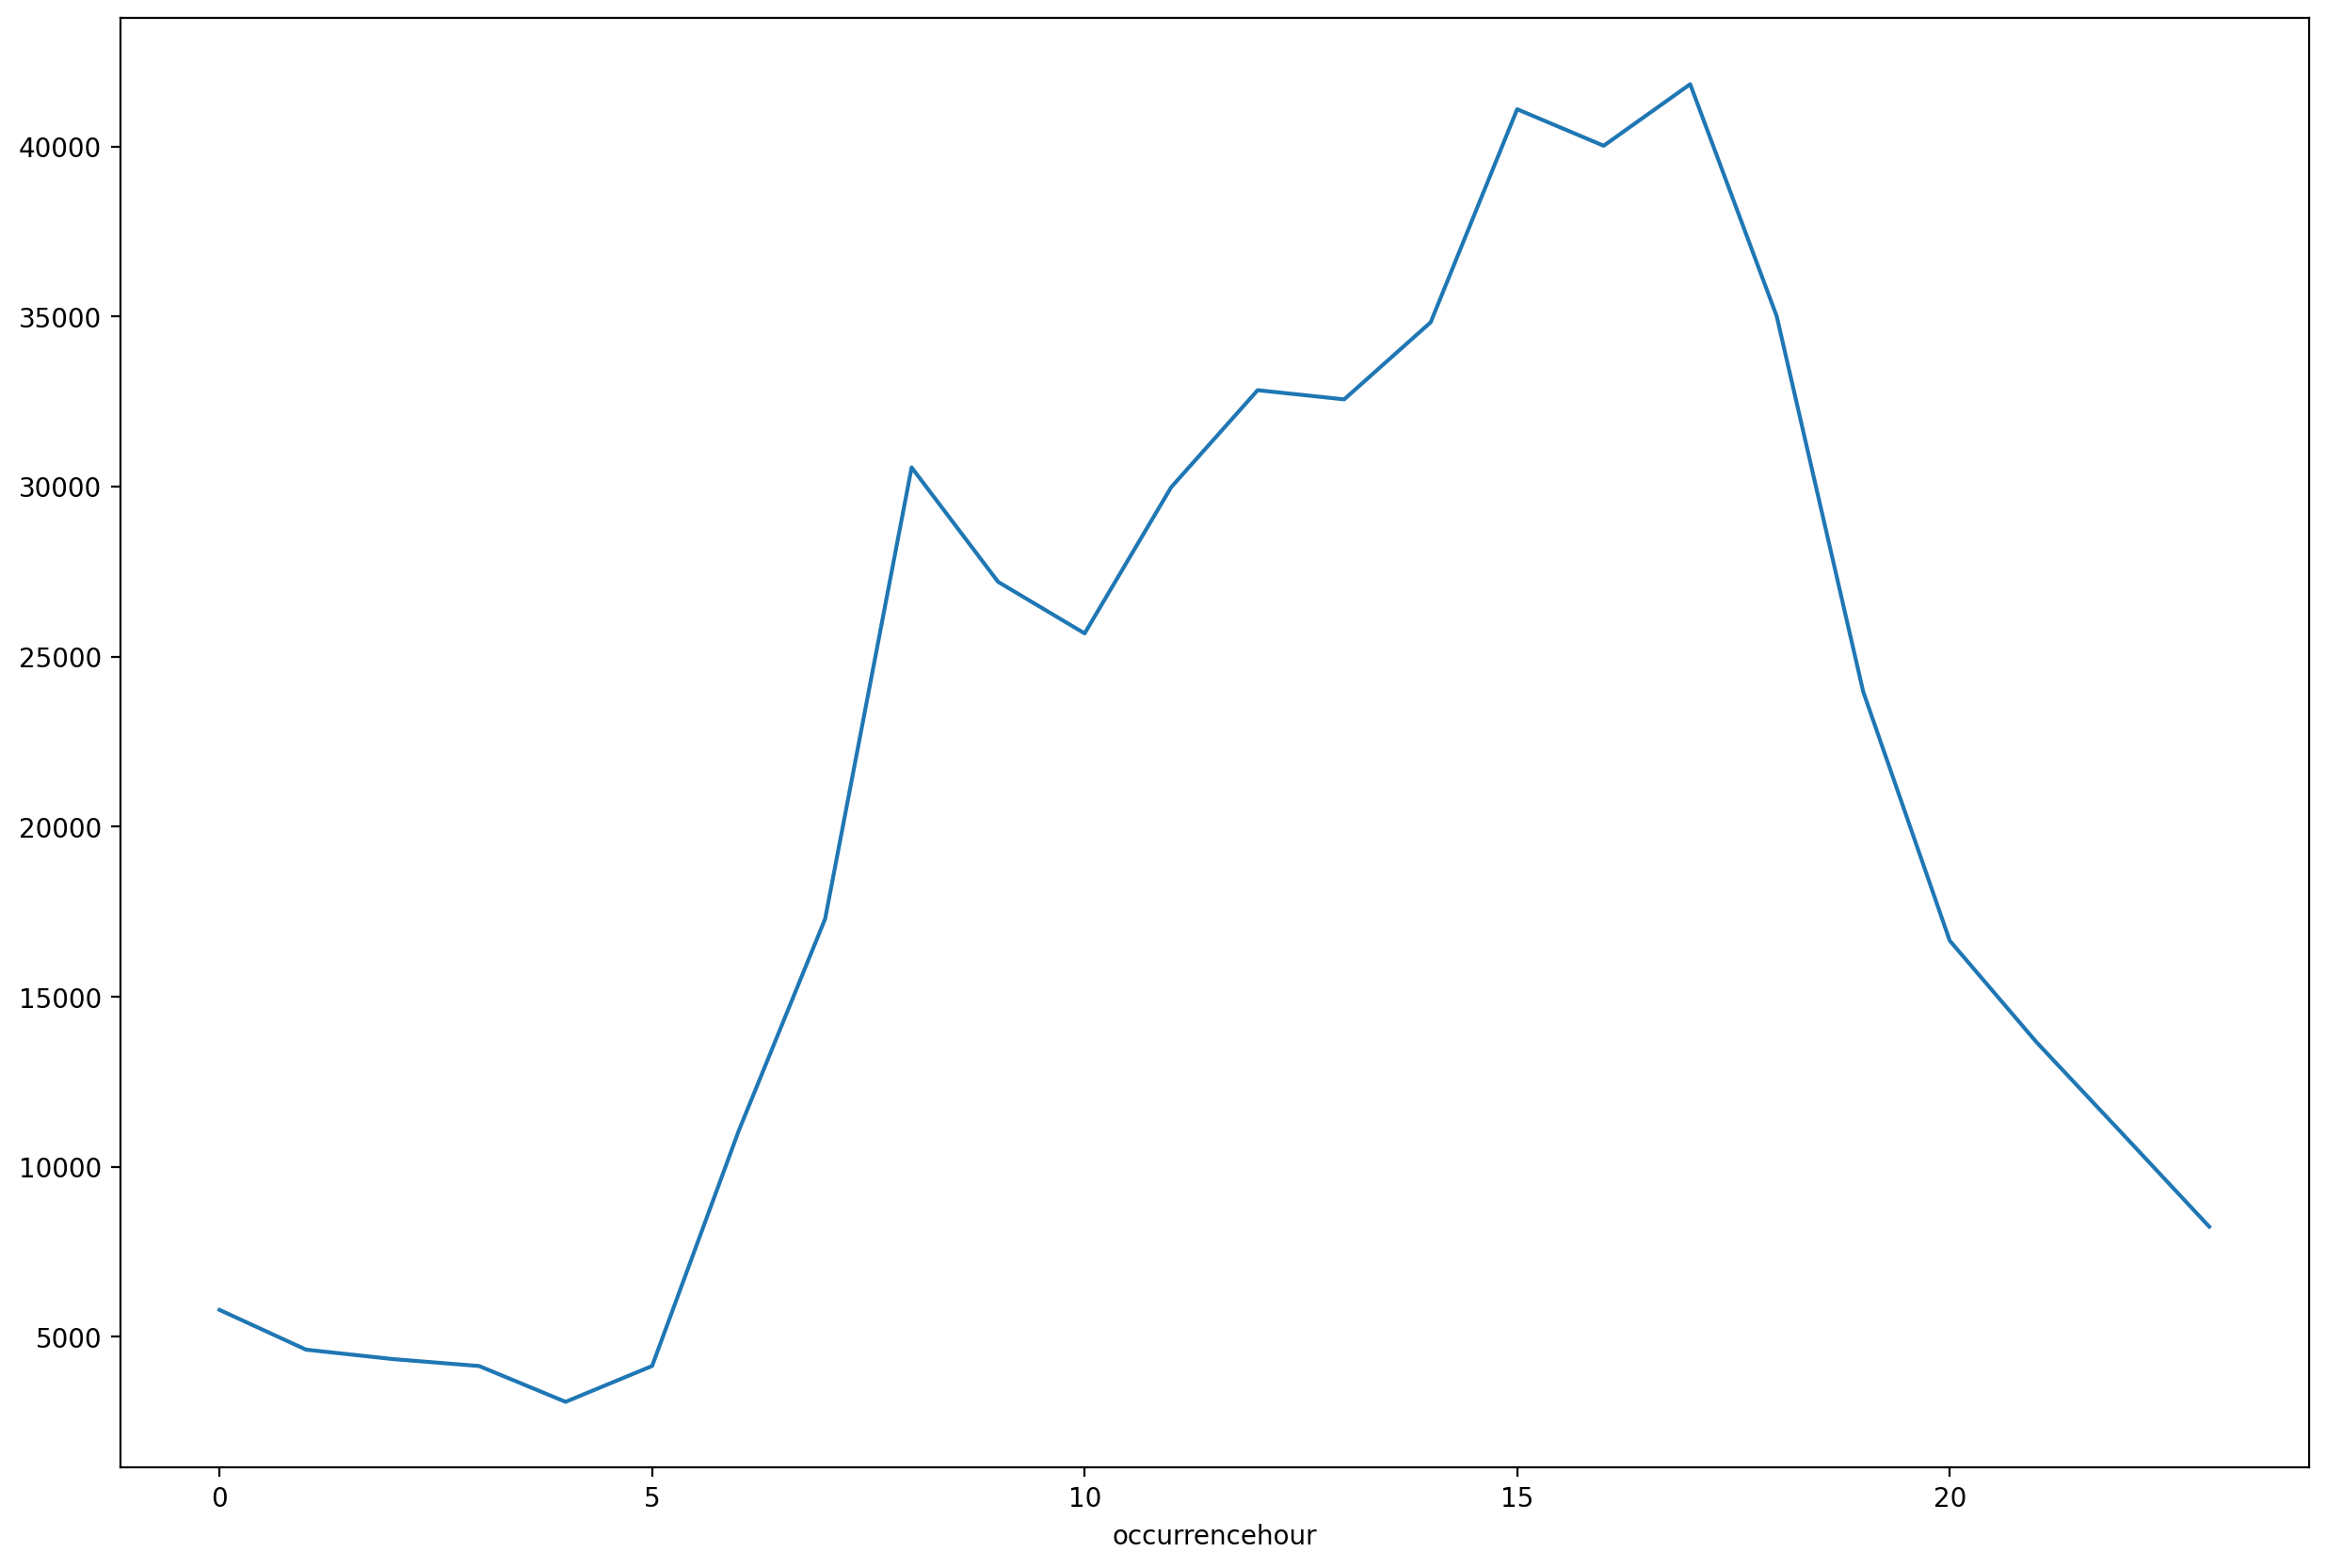

In [35]:
# makes sense that most of the traffic collisions happen in the afternoon when roads are most busy
collision_df.groupby(['occurrencehour']).size().plot()

In [36]:
collision_df['occurrencedate'][0]

Timestamp('2014-02-07 05:00:00+0000', tz='UTC')

In [37]:
collision_df['occurrencedate'][0].replace(hour=int(collision_df['occurrencehour'][0]), 
                                          tzinfo=dt.timezone(dt.timedelta(hours=-4))) # Toronto GMT-4

Timestamp('2014-02-07 16:00:00-0400', tz='UTC-04:00')

In [38]:
dates = []
for date, hour in zip(collision_df.occurrencedate, collision_df.occurrencehour):
    dates.append(date.replace(hour=int(hour), tzinfo=dt.timezone(dt.timedelta(hours=-4)))) # Toronto GMT-4

In [39]:
collision_df['occurrencedate'] = dates

### inconsistency in hood_ID and neighbourhood

In [40]:
# check if hood_id and Neighbourhood are 1-to-1
# number of unique values in hood_id and neighbourhood should be the same
print(len(collision_df.hood_id.unique()), len(collision_df.Neighbourhood.unique()))

141 141


In [41]:
check_duplicate = collision_df.groupby(['hood_id','Neighbourhood']).size().reset_index(name='counts')

In [42]:
# duplicates in hood_id since some record are of int type, while some are strings
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

Empty DataFrame
Columns: [hood_id, Neighbourhood, counts]
Index: []

In [43]:
# duplicate neighbourhood values due to white space
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')[:2].values

array([], shape=(0, 3), dtype=object)

In [44]:
collision_df['Neighbourhood'] = collision_df['Neighbourhood'].str.strip()

In [45]:
# no more duplicates due to white space but not have 2 due to format issues
check_duplicate = collision_df.groupby(['hood_id','Neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

Empty DataFrame
Columns: [hood_id, Neighbourhood, counts]
Index: []

In [46]:
# fix duplicate neighbourhood
collision_df.loc[(collision_df.hood_id == '117') & (collision_df.Neighbourhood == 'LAmoreaux'), 'Neighbourhood'] = "L'Amoreaux"
collision_df.loc[(collision_df.hood_id == '118') & (collision_df.Neighbourhood == 'Tam OShanter-Sullivan'), 'Neighbourhood'] = "Tam O'Shanter-Sullivan"

In [47]:
# no more duplicates
check_duplicate = collision_df.groupby(['hood_id','Neighbourhood']).size().reset_index(name='counts')
check_duplicate[check_duplicate.duplicated(subset='hood_id', keep=False)].sort_values(by='hood_id')

Empty DataFrame
Columns: [hood_id, Neighbourhood, counts]
Index: []

In [48]:
check_duplicate[check_duplicate.duplicated(subset='Neighbourhood', keep=False)].sort_values(by='Neighbourhood')

Empty DataFrame
Columns: [hood_id, Neighbourhood, counts]
Index: []

### inconsistency vs neighbourhood boundary

In [49]:
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'hood_id']], collision_df[['hood_id', 'Neighbourhood']], on=['hood_id'], how='outer')
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

Neighbourhood_x hood_id   Neighbourhood_y
156404                    O'Connor-Parkview      54  OConnor-Parkview
422634  Mimico (includes Humber Bay Shores)      17               NaN
422635                                  NaN     NSA               NSA

In [50]:
collision_df.loc[(collision_df.hood_id == '54') & (collision_df.Neighbourhood == 'OConnor-Parkview'), 'Neighbourhood'] = "O'Connor-Parkview"

In [51]:
# now neighbourhoods are consistent
merge_df = pd.merge(neighbourhoods[['Neighbourhood', 'hood_id']], collision_df[['hood_id', 'Neighbourhood']], on=['hood_id'])
merge_df[merge_df['Neighbourhood_x'] != merge_df['Neighbourhood_y']].drop_duplicates(subset=['Neighbourhood_x'])

Empty DataFrame
Columns: [Neighbourhood_x, hood_id, Neighbourhood_y]
Index: []

### inconsistentcy in hood_id

In [52]:
sorted(collision_df.hood_id.unique())

['1',
 '10',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '11',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '13',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '14',
 '140',
 '15',
 '16',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '

In [53]:
collision_df[collision_df.hood_id == '17']

Empty DataFrame
Columns: [X, Y, ObjectId, event_unique_id, occurrencedate, occurrencemonth, occurrencedayofweek, occurrenceyear, occurrencehour, Division, Neighbourhood, Fatalities, Injury_Collisions, FTR_Collisions, PD_Collisions, Long, Lat, ObjectId2, hood_id, occurrenceday, occurrencedayofyear]
Index: []

In [54]:
collision_df[collision_df.hood_id == 'includes Humber Bay Shores'].head(1)

X             Y  ObjectId event_unique_id  \
400014 -8.847005e+06  5.408449e+06    400404  GO-20148003867   

                  occurrencedate occurrencemonth occurrencedayofweek  \
400014 2014-01-27 14:00:00-04:00         January              Monday   

        occurrenceyear  occurrencehour Division Neighbourhood  Fatalities  \
400014            2014              14      D22        Mimico           0   

       Injury_Collisions FTR_Collisions PD_Collisions    Long        Lat  \
400014                NO             NO           YES -79.474  43.630571   

        ObjectId2                     hood_id  occurrenceday  \
400014     400015  includes Humber Bay Shores           27.0   

        occurrencedayofyear  
400014                 27.0

In [55]:
collision_df.loc[collision_df.hood_id == 'includes Humber Bay Shores', 'Neighbourhood'] = 'Mimico (includes Humber Bay Shores)'
collision_df.loc[collision_df.hood_id == 'includes Humber Bay Shores', 'hood_id'] = '17'

In [56]:
len(collision_df.hood_id.unique())

141

In [57]:
len(collision_df.Neighbourhood.unique())

141

## Fixing data types

In [58]:
collision_df.Injury_Collisions.unique()

array(['NO', 'YES'], dtype=object)

In [59]:
mapping = {'YES': 1, 'NO': 0}
collision_df.replace({'Injury_Collisions': mapping,
                      'FTR_Collisions': mapping,
                      'PD_Collisions': mapping}, inplace=True)

## Impute missing long and lat

In [60]:
collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0), ["Neighbourhood"]].value_counts()

Neighbourhood               
NSA                             69252
Wexford/Maryvale                   64
West Hill                          26
Kennedy Park                       15
Yorkdale-Glen Park                 13
Hillcrest Village                  12
L'Amoreaux                         11
Glenfield-Jane Heights              8
Clairlea-Birchmount                 8
York University Heights             7
Bendale                             7
Highland Creek                      5
Agincourt South-Malvern West        5
Black Creek                         5
Islington-City Centre West          4
Bay Street Corridor                 3
Bayview Woods-Steeles               3
Bathurst Manor                      2
Church-Yonge Corridor               2
Westminster-Branson                 2
West Humber-Clairville              2
Pelmo Park-Humberlea                2
St.Andrew-Windfields                1
Woburn                              1
Bedford Park-Nortown                1
High Park North      

In [61]:
# We can only estimate the location for those crimes with a neighbourhood associated to them 
# Drow rows without information about location and associated neighbourhood
collision_df = collision_df[~((collision_df['Long'] == 0) & (collision_df['Lat'] == 0) & (collision_df['Neighbourhood'] == "NSA"))].reset_index(drop=True)

In [62]:
missing_location = collision_df.loc[(collision_df['Long'] == 0) & (collision_df['Lat'] == 0)].index
collision_df.loc[missing_location]

X    Y  ObjectId event_unique_id            occurrencedate  \
0    0.0  0.0       278  GO-20141591056 2014-02-24 17:00:00-04:00   
1    0.0  0.0      1246  GO-20143120578 2014-10-17 09:00:00-04:00   
2    0.0  0.0     21564  GO-20168056919 2016-12-17 09:00:00-04:00   
3    0.0  0.0     21709  GO-20168059092 2016-12-27 18:00:00-04:00   
4    0.0  0.0     21277  GO-20168053844 2016-11-30 18:00:00-04:00   
..   ...  ...       ...             ...                       ...   
713  0.0  0.0     69463  GO-20198030463 2019-05-20 08:00:00-04:00   
714  0.0  0.0     69464  GO-20198076663 2019-12-21 12:00:00-04:00   
715  0.0  0.0     69465  GO-20201700319 2020-09-08 15:00:00-04:00   
716  0.0  0.0     69466  GO-20208029200 2020-09-30 15:00:00-04:00   
720  0.0  0.0     69072  GO-20218011943 2021-06-14 12:00:00-04:00   

    occurrencemonth occurrencedayofweek  occurrenceyear  occurrencehour  \
0          February              Monday            2014              17   
1           October              Friday            2014               9   
2          December            Saturday            2016               9   
3          December             Tuesday            2016              18   
4          November           Wednesday            2016              18   
..              ...                 ...             ...             ...   
713             May              Monday            2019               8   
714        December            Saturday            2019              12   
715       September             Tuesday            2020              15   
716       September           Wednesday            2020              15   
720            June              Monday            2021              12   

    Division            Neighbourhood  Fatalities  Injury_Collisions  \
0        D32     St.Andrew-Windfields           0                  0   
1        D31   Glenfield-Jane Heights           0                  0   
2        D31  York University Heights           0                  0   
3        D32       Yorkdale-Glen Park           0                  0   
4        D33        Hillcrest Village           0                  0   
..       ...                      ...         ...                ...   
713      D43      Lawrence Park South           0                  1   
714      D42   West Humber-Clairville           0                  0   
715      D33        Parkwoods-Donalda           0                  0   
716      D32      Lawrence Park North           0                  0   
720      D41      Clairlea-Birchmount           0                  0   

     FTR_Collisions  PD_Collisions  Long  Lat  ObjectId2 hood_id  \
0                 1              0   0.0  0.0        178      40   
1                 0              1   0.0  0.0       1046      25   
2                 0              1   0.0  0.0      21094      27   
3                 1              0   0.0  0.0      21162      31   
4                 0              1   0.0  0.0      21340      48   
..              ...            ...   ...  ...        ...     ...   
713               0              0   0.0  0.0      69919     103   
714               0              1   0.0  0.0      69921       1   
715               1              1   0.0  0.0      69923      45   
716               0              1   0.0  0.0      69925     105   
720               0              1   0.0  0.0      69941     120   

     occurrenceday  occurrencedayofyear  
0             24.0                 55.0  
1             17.0                290.0  
2             17.0                352.0  
3             27.0                362.0  
4             30.0                335.0  
..             ...                  ...  
713           20.0                140.0  
714           21.0                355.0  
715            8.0                252.0  
716           30.0                274.0  
720           14.0                165.0  

[218 rows x 21 columns]

In [63]:
missing_count = collision_df.loc[missing_location]['hood_id'].value_counts()
missing_count = missing_count.reset_index(drop=False).rename(columns={'index':'hood_id', 'hood_id':'count'})
missing_count

hood_id  count
0      119     64
1      136     26
2      124     15
3       31     13
4       48     12
5      117     11
6       25      8
7      120      8
8       27      7
9      127      7
10     134      5
11     128      5
12      24      5
13      14      4
14      76      3
15      49      3
16      34      2
17      35      2
18      23      2
19      75      2
20       1      2
21      88      1
22      40      1
23     103      1
24      45      1
25     123      1
26      39      1
27     137      1
28      47      1
29     122      1
30     139      1
31      21      1
32     105      1

### Generate random points within neighbourhood

In [64]:
# randomly generate points within a defined neighbourhood
# https://gis.stackexchange.com/questions/207731/generating-random-coordinates-in-multipolygon-in-python
def generate_random(number, hood_id):
    selected_neighbourhood = neighbourhoods.loc[neighbourhoods['hood_id'] == str(hood_id)]
    polygon = selected_neighbourhood['geometry']
    points_x = []
    points_y = []
    count = 0
    try: 
        minx, miny, maxx, maxy = polygon.bounds.values.flatten().tolist()
    except ValueError:
        print(selected_neighbourhood)
        print(f"No geometry for {hood_id}")
    while len(points_x) < number:
        pnt = shapely.geometry.Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
        if polygon.contains(pnt).values[0]:
            points_x.append(pnt.x)
            points_y.append(pnt.y)
        count += 1
    print(f"{count} points generated but only include the {len(points_x)} points within the neighbourhood")
    return pd.Series([points_x, points_y])

In [65]:
np.random.seed(123)
missing_count[['Long', 'Lat']] = missing_count.apply(lambda x: generate_random(x['count'],x['hood_id']), axis=1)

86 points generated but only include the 64 points within the neighbourhood
49 points generated but only include the 26 points within the neighbourhood
34 points generated but only include the 15 points within the neighbourhood
15 points generated but only include the 13 points within the neighbourhood
17 points generated but only include the 12 points within the neighbourhood
29 points generated but only include the 11 points within the neighbourhood
10 points generated but only include the 8 points within the neighbourhood
19 points generated but only include the 8 points within the neighbourhood
12 points generated but only include the 7 points within the neighbourhood
7 points generated but only include the 7 points within the neighbourhood
10 points generated but only include the 5 points within the neighbourhood
10 points generated but only include the 5 points within the neighbourhood
7 points generated but only include the 5 points within the neighbourhood
10 points generated b

In [66]:
# random locations generated for each neighbourhood with missing long and lat values
missing_count['len'] = missing_count['Long'].apply(lambda x: len(x))
missing_count

hood_id  count                                               Long  \
0      119     64  [-79.2905474645034, -79.31024017310659, -79.28...   
1      136     26  [-79.19911824880309, -79.18040350946745, -79.1...   
2      124     15  [-79.26654982146835, -79.27463062049003, -79.2...   
3       31     13  [-79.45996226267624, -79.46065952752981, -79.4...   
4       48     12  [-79.3520875268021, -79.33868359752705, -79.36...   
5      117     11  [-79.30228548159286, -79.29101438573844, -79.3...   
6       25      8  [-79.51354369472986, -79.51079945917418, -79.5...   
7      120      8  [-79.29825934015967, -79.28250707547197, -79.2...   
8       27      7  [-79.49825254767276, -79.48530259746411, -79.4...   
9      127      7  [-79.25473825213193, -79.26135086018229, -79.2...   
10     134      5  [-79.1893387773203, -79.17939553838062, -79.16...   
11     128      5  [-79.2503055784295, -79.25119545640389, -79.28...   
12      24      5  [-79.5149395013671, -79.51380050953529, -79.52...   
13      14      4  [-79.55183856163947, -79.51971763524456, -79.5...   
14      76      3  [-79.38608811840274, -79.38800650395268, -79.3...   
15      49      3  [-79.37763537091558, -79.37362196670915, -79.3...   
16      34      2             [-79.4591302165564, -79.4376689202518]   
17      35      2           [-79.44666524457685, -79.44972149213906]   
18      23      2           [-79.53198844445379, -79.51341201492004]   
19      75      2            [-79.3749467911933, -79.37381429183138]   
20       1      2            [-79.5974118053986, -79.61625326309967]   
21      88      1                               [-79.45269415798322]   
22      40      1                               [-79.40203401829243]   
23     103      1                               [-79.41296704850241]   
24      45      1                               [-79.34275376401087]   
25     123      1                               [-79.23499592589191]   
26      39      1                               [-79.41606535236926]   
27     137      1                               [-79.20423192685666]   
28      47      1                               [-79.35377229911848]   
29     122      1                                [-79.2616360054696]   
30     139      1                               [-79.21269584742495]   
31      21      1                               [-79.53605837386374]   
32     105      1                               [-79.41576749547013]   

                                                  Lat  len  
0   [43.73845162529402, 43.75118356521948, 43.7450...   64  
1   [43.75765197946631, 43.76546946821289, 43.7572...   26  
2   [43.72232249578001, 43.7224000798009, 43.71780...   15  
3   [43.707040006978474, 43.71897347621641, 43.705...   13  
4   [43.80780466875634, 43.80490053510152, 43.8091...   12  
5   [43.79210334082548, 43.796763995859656, 43.796...   11  
6   [43.74301390592894, 43.756067443593345, 43.739...    8  
7   [43.717965362775196, 43.7212468235057, 43.7092...    8  
8   [43.76390670967839, 43.7606371871618, 43.76592...    7  
9   [43.77002794299879, 43.77322670528096, 43.7432...    7  
10  [43.79020305159532, 43.784133923069405, 43.790...    5  
11  [43.79240406783051, 43.79558093099783, 43.7898...    5  
12  [43.76602678246873, 43.769342047468875, 43.767...    5  
13  [43.656669645524985, 43.62649799959126, 43.640...    4  
14  [43.651475803830905, 43.66905924606806, 43.662...    3  
15  [43.78964045957596, 43.80570677966695, 43.7936...    3  
16             [43.75476909653474, 43.75656387973003]    2  
17             [43.78648869736756, 43.77945475662757]    2  
18            [43.71661157762134, 43.717029278441245]    2  
19             [43.65777541240674, 43.64876866211275]    2  
20            [43.710361164627216, 43.75283915477821]    2  
21                               [43.656456935556946]    1  
22                               [43.748097460343914]    1  
23                                [43.71496742856173]    1  
24                           

In [67]:
# impute the missing long and lat values
for i in missing_count["hood_id"].unique():    
    index = (collision_df['hood_id'] == str(i)) & ((collision_df['Long'] == 0) | (collision_df['Lat'] == 0))
    collision_df.loc[index, ['Long', 'Lat']] = pd.DataFrame([np.where(collision_df.loc[index, 'Long'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['Long'].iloc[0],
                                                                      collision_df.loc[index, 'Long']),
                                                             np.where(collision_df.loc[index, 'Lat'] == 0, 
                                                                      missing_count[missing_count['hood_id'] == str(i)]['Lat'].iloc[0],
                                                                      collision_df.loc[index, 'Lat'])]).T.values

In [68]:
# check missing long and lat values are now imputed
collision_df.loc[missing_location]

X    Y  ObjectId event_unique_id            occurrencedate  \
0    0.0  0.0       278  GO-20141591056 2014-02-24 17:00:00-04:00   
1    0.0  0.0      1246  GO-20143120578 2014-10-17 09:00:00-04:00   
2    0.0  0.0     21564  GO-20168056919 2016-12-17 09:00:00-04:00   
3    0.0  0.0     21709  GO-20168059092 2016-12-27 18:00:00-04:00   
4    0.0  0.0     21277  GO-20168053844 2016-11-30 18:00:00-04:00   
..   ...  ...       ...             ...                       ...   
713  0.0  0.0     69463  GO-20198030463 2019-05-20 08:00:00-04:00   
714  0.0  0.0     69464  GO-20198076663 2019-12-21 12:00:00-04:00   
715  0.0  0.0     69465  GO-20201700319 2020-09-08 15:00:00-04:00   
716  0.0  0.0     69466  GO-20208029200 2020-09-30 15:00:00-04:00   
720  0.0  0.0     69072  GO-20218011943 2021-06-14 12:00:00-04:00   

    occurrencemonth occurrencedayofweek  occurrenceyear  occurrencehour  \
0          February              Monday            2014              17   
1           October              Friday            2014               9   
2          December            Saturday            2016               9   
3          December             Tuesday            2016              18   
4          November           Wednesday            2016              18   
..              ...                 ...             ...             ...   
713             May              Monday            2019               8   
714        December            Saturday            2019              12   
715       September             Tuesday            2020              15   
716       September           Wednesday            2020              15   
720            June              Monday            2021              12   

    Division            Neighbourhood  Fatalities  Injury_Collisions  \
0        D32     St.Andrew-Windfields           0                  0   
1        D31   Glenfield-Jane Heights           0                  0   
2        D31  York University Heights           0                  0   
3        D32       Yorkdale-Glen Park           0                  0   
4        D33        Hillcrest Village           0                  0   
..       ...                      ...         ...                ...   
713      D43      Lawrence Park South           0                  1   
714      D42   West Humber-Clairville           0                  0   
715      D33        Parkwoods-Donalda           0                  0   
716      D32      Lawrence Park North           0                  0   
720      D41      Clairlea-Birchmount           0                  0   

     FTR_Collisions  PD_Collisions       Long        Lat  ObjectId2 hood_id  \
0                 1              0 -79.402034  43.748097        178      40   
1                 0              1 -79.513544  43.743014       1046      25   
2                 0              1 -79.498253  43.763907      21094      27   
3                 1              0 -79.459962  43.707040      21162      31   
4                 0              1 -79.352088  43.807805      21340      48   
..              ...            ...        ...        ...        ...     ...   
713               0              0 -79.412967  43.714967      69919     103   
714               0              1 -79.616253  43.752839      69921       1   
715               1              1 -79.342754  43.761909      69923      45   
716               0              1 -79.415767  43.732380      69925     105   
720               0              1 -79.281258  43.727670      69941     120   

     occurrenceday  occurrencedayofyear  
0             24.0                 55.0  
1             17.0                290.0  
2             17.0                352.0  
3             27.0                362.0  
4             30.0                335.0  
..             ...                  ...  
713           20.0                140.0  
714           21.0                355.0  
715            8.0                252.0  
716           30.0                274.0  
7

### Add geometry points

In [69]:
collision_df['geometry'] = collision_df.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [70]:
collision_point = gpd.GeoDataFrame(collision_df, crs='epsg:' + str(epsg_3d), geometry='geometry')

<AxesSubplot:>

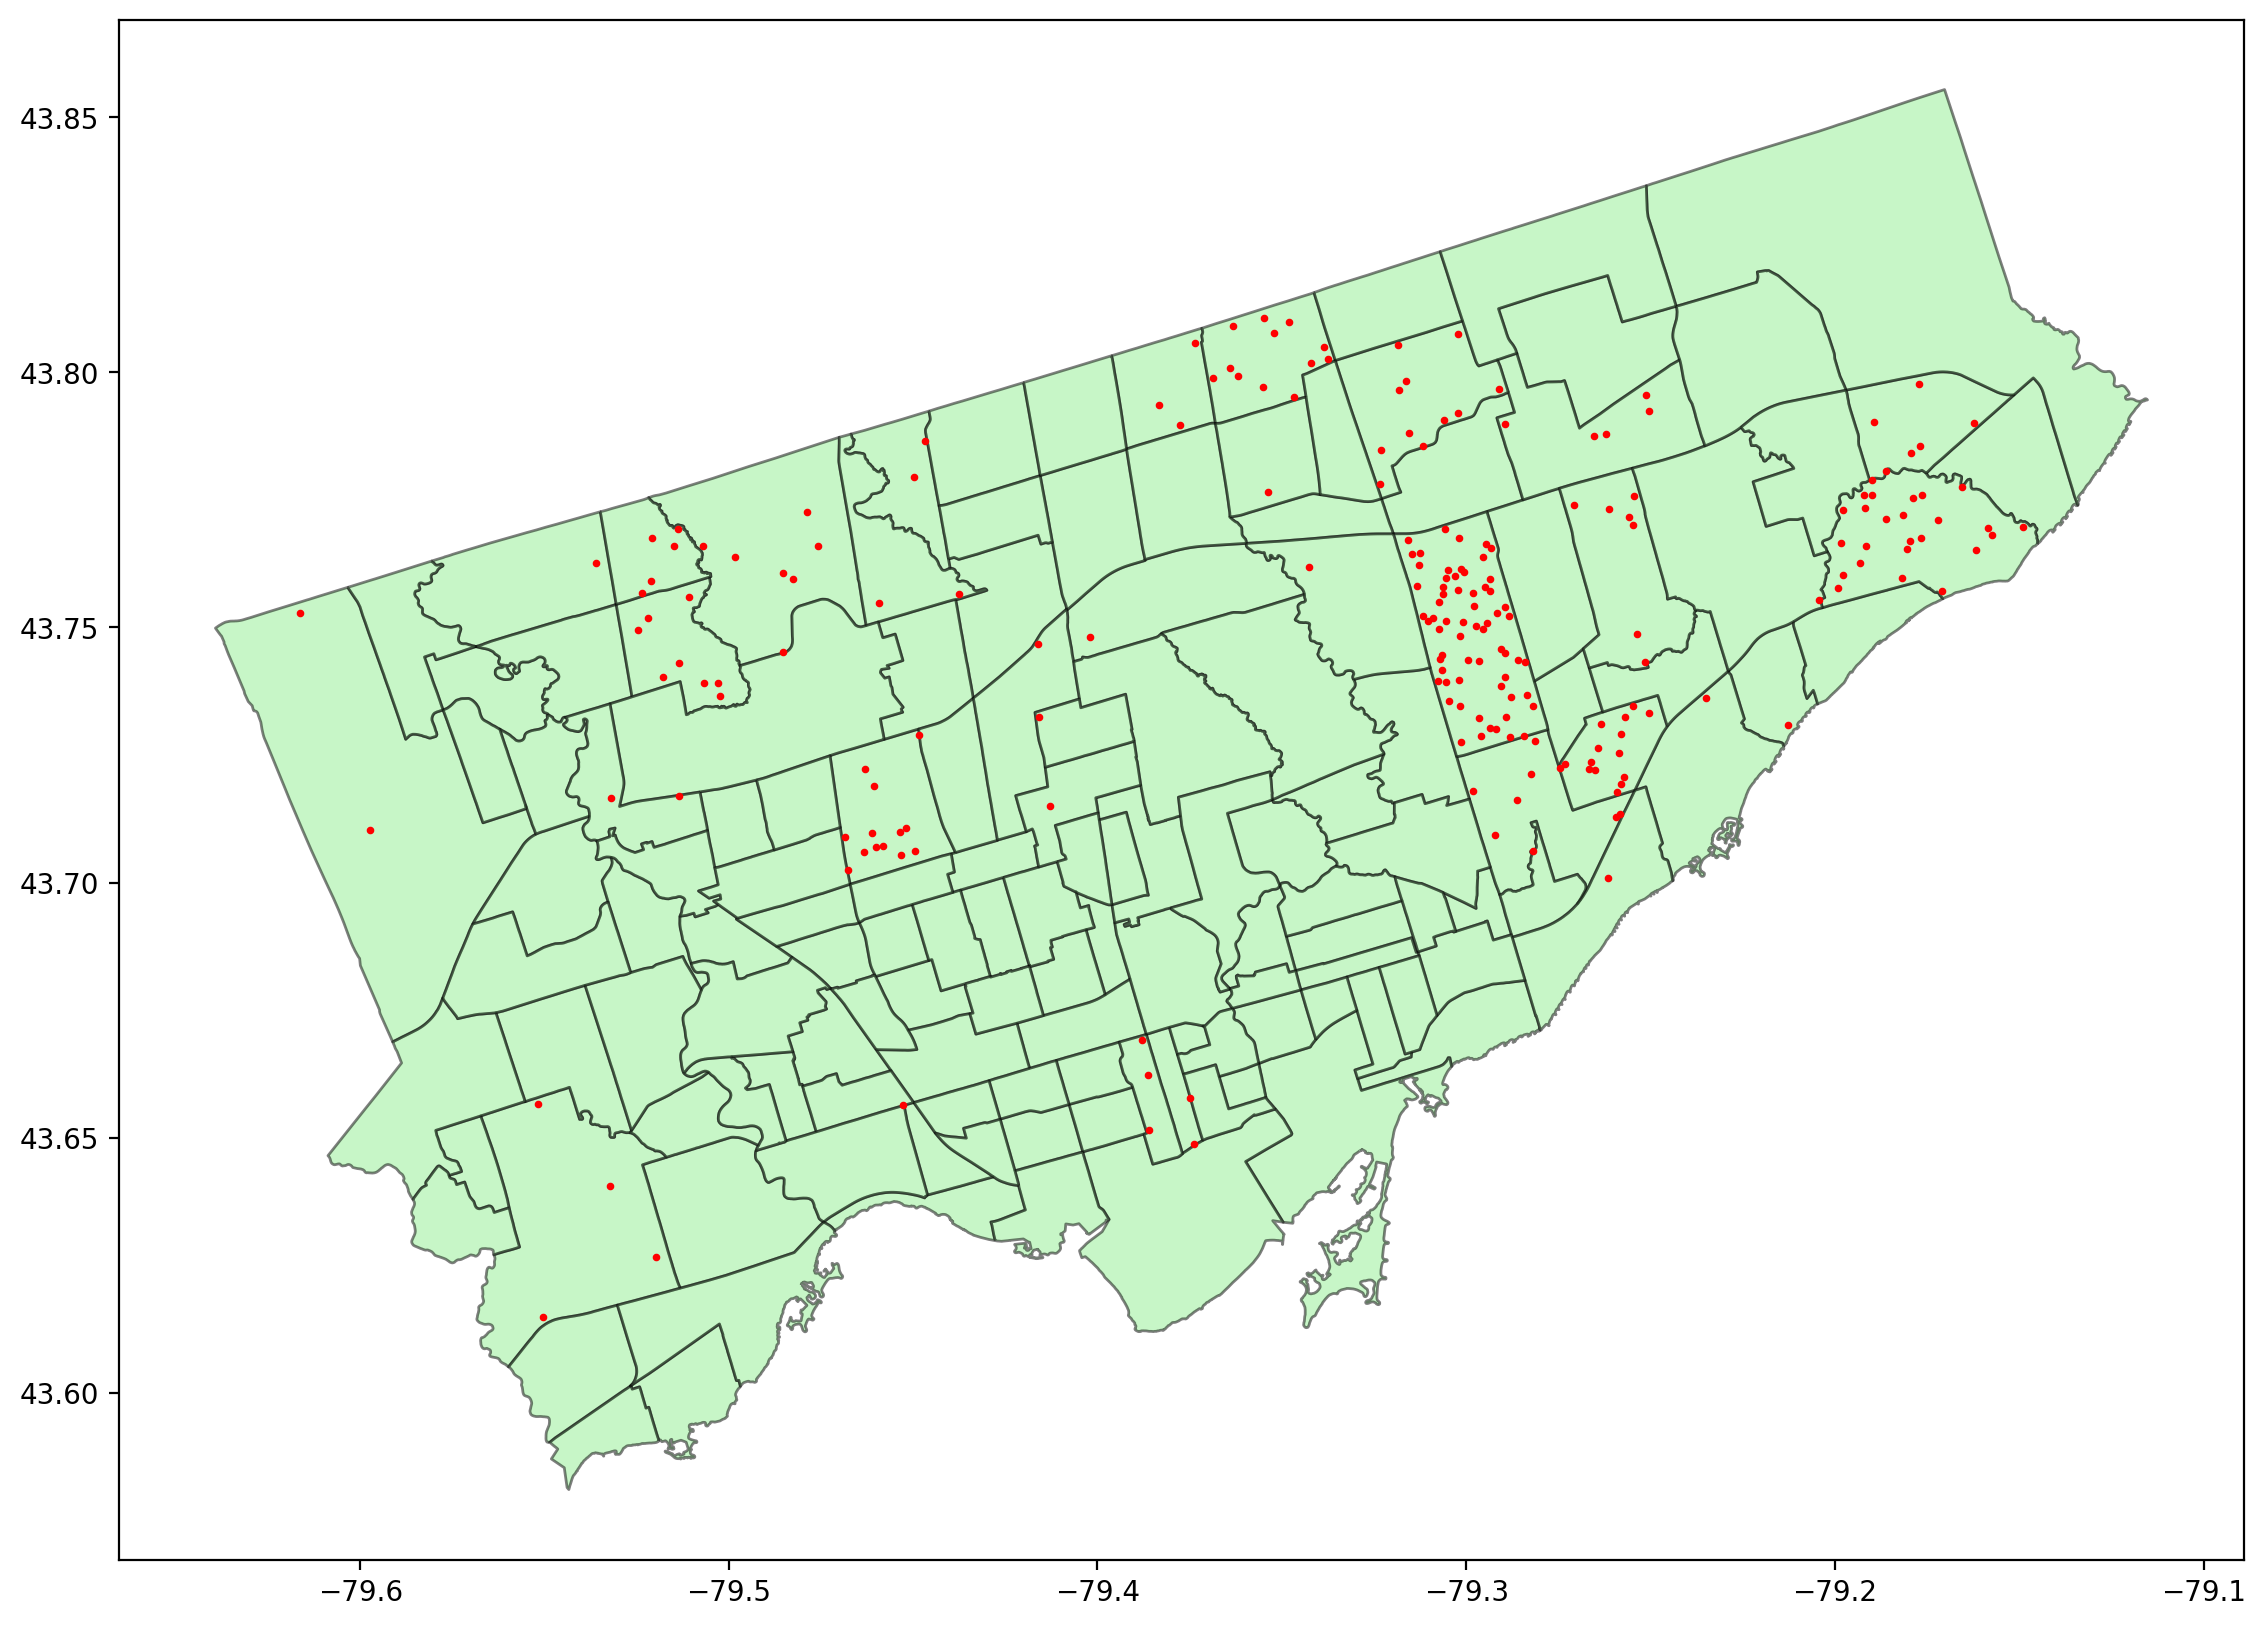

In [71]:
# show that random points generated to impute missing location are within the neighbourhoods
# no red dots should be outside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[missing_location].plot(ax=ax, color = 'red', markersize = 3)

## NSA is not really 'Not Specified'

<AxesSubplot:>

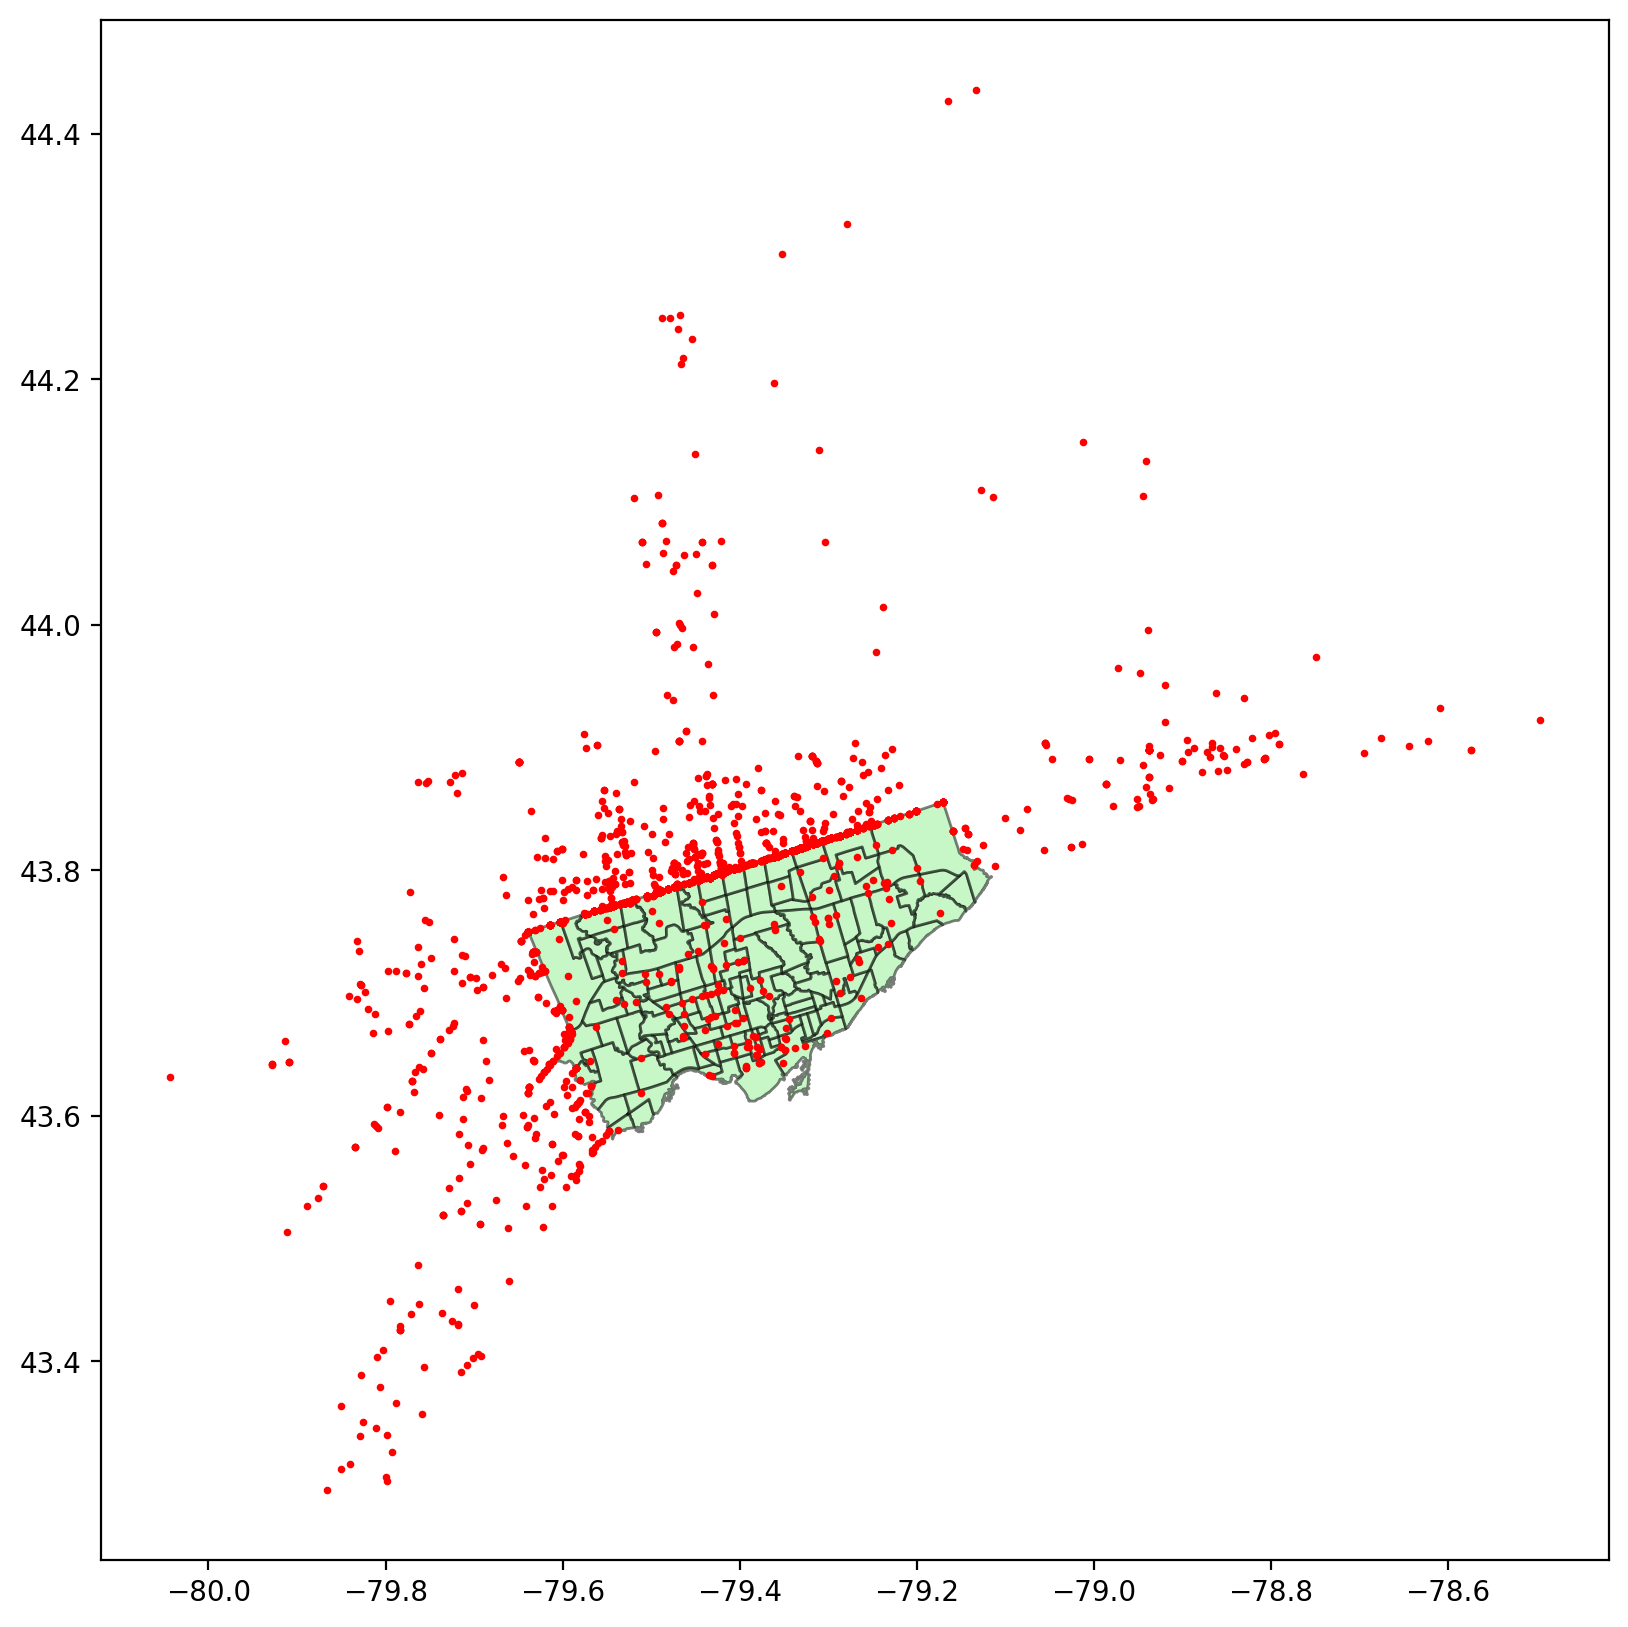

In [72]:
# some locations marked as NSA are actually within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

In [73]:
# get the points contained within the neighbourhood
NSA_within_neighbourhood = gpd.sjoin(collision_point[collision_point['Neighbourhood'] == 'NSA'], 
                                    neighbourhoods, 
                                    op='intersects')
collision_point.loc[NSA_within_neighbourhood.index, ['hood_id', 'Neighbourhood']] = NSA_within_neighbourhood[['hood_id_right', 'Neighbourhood_right']].values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot:>

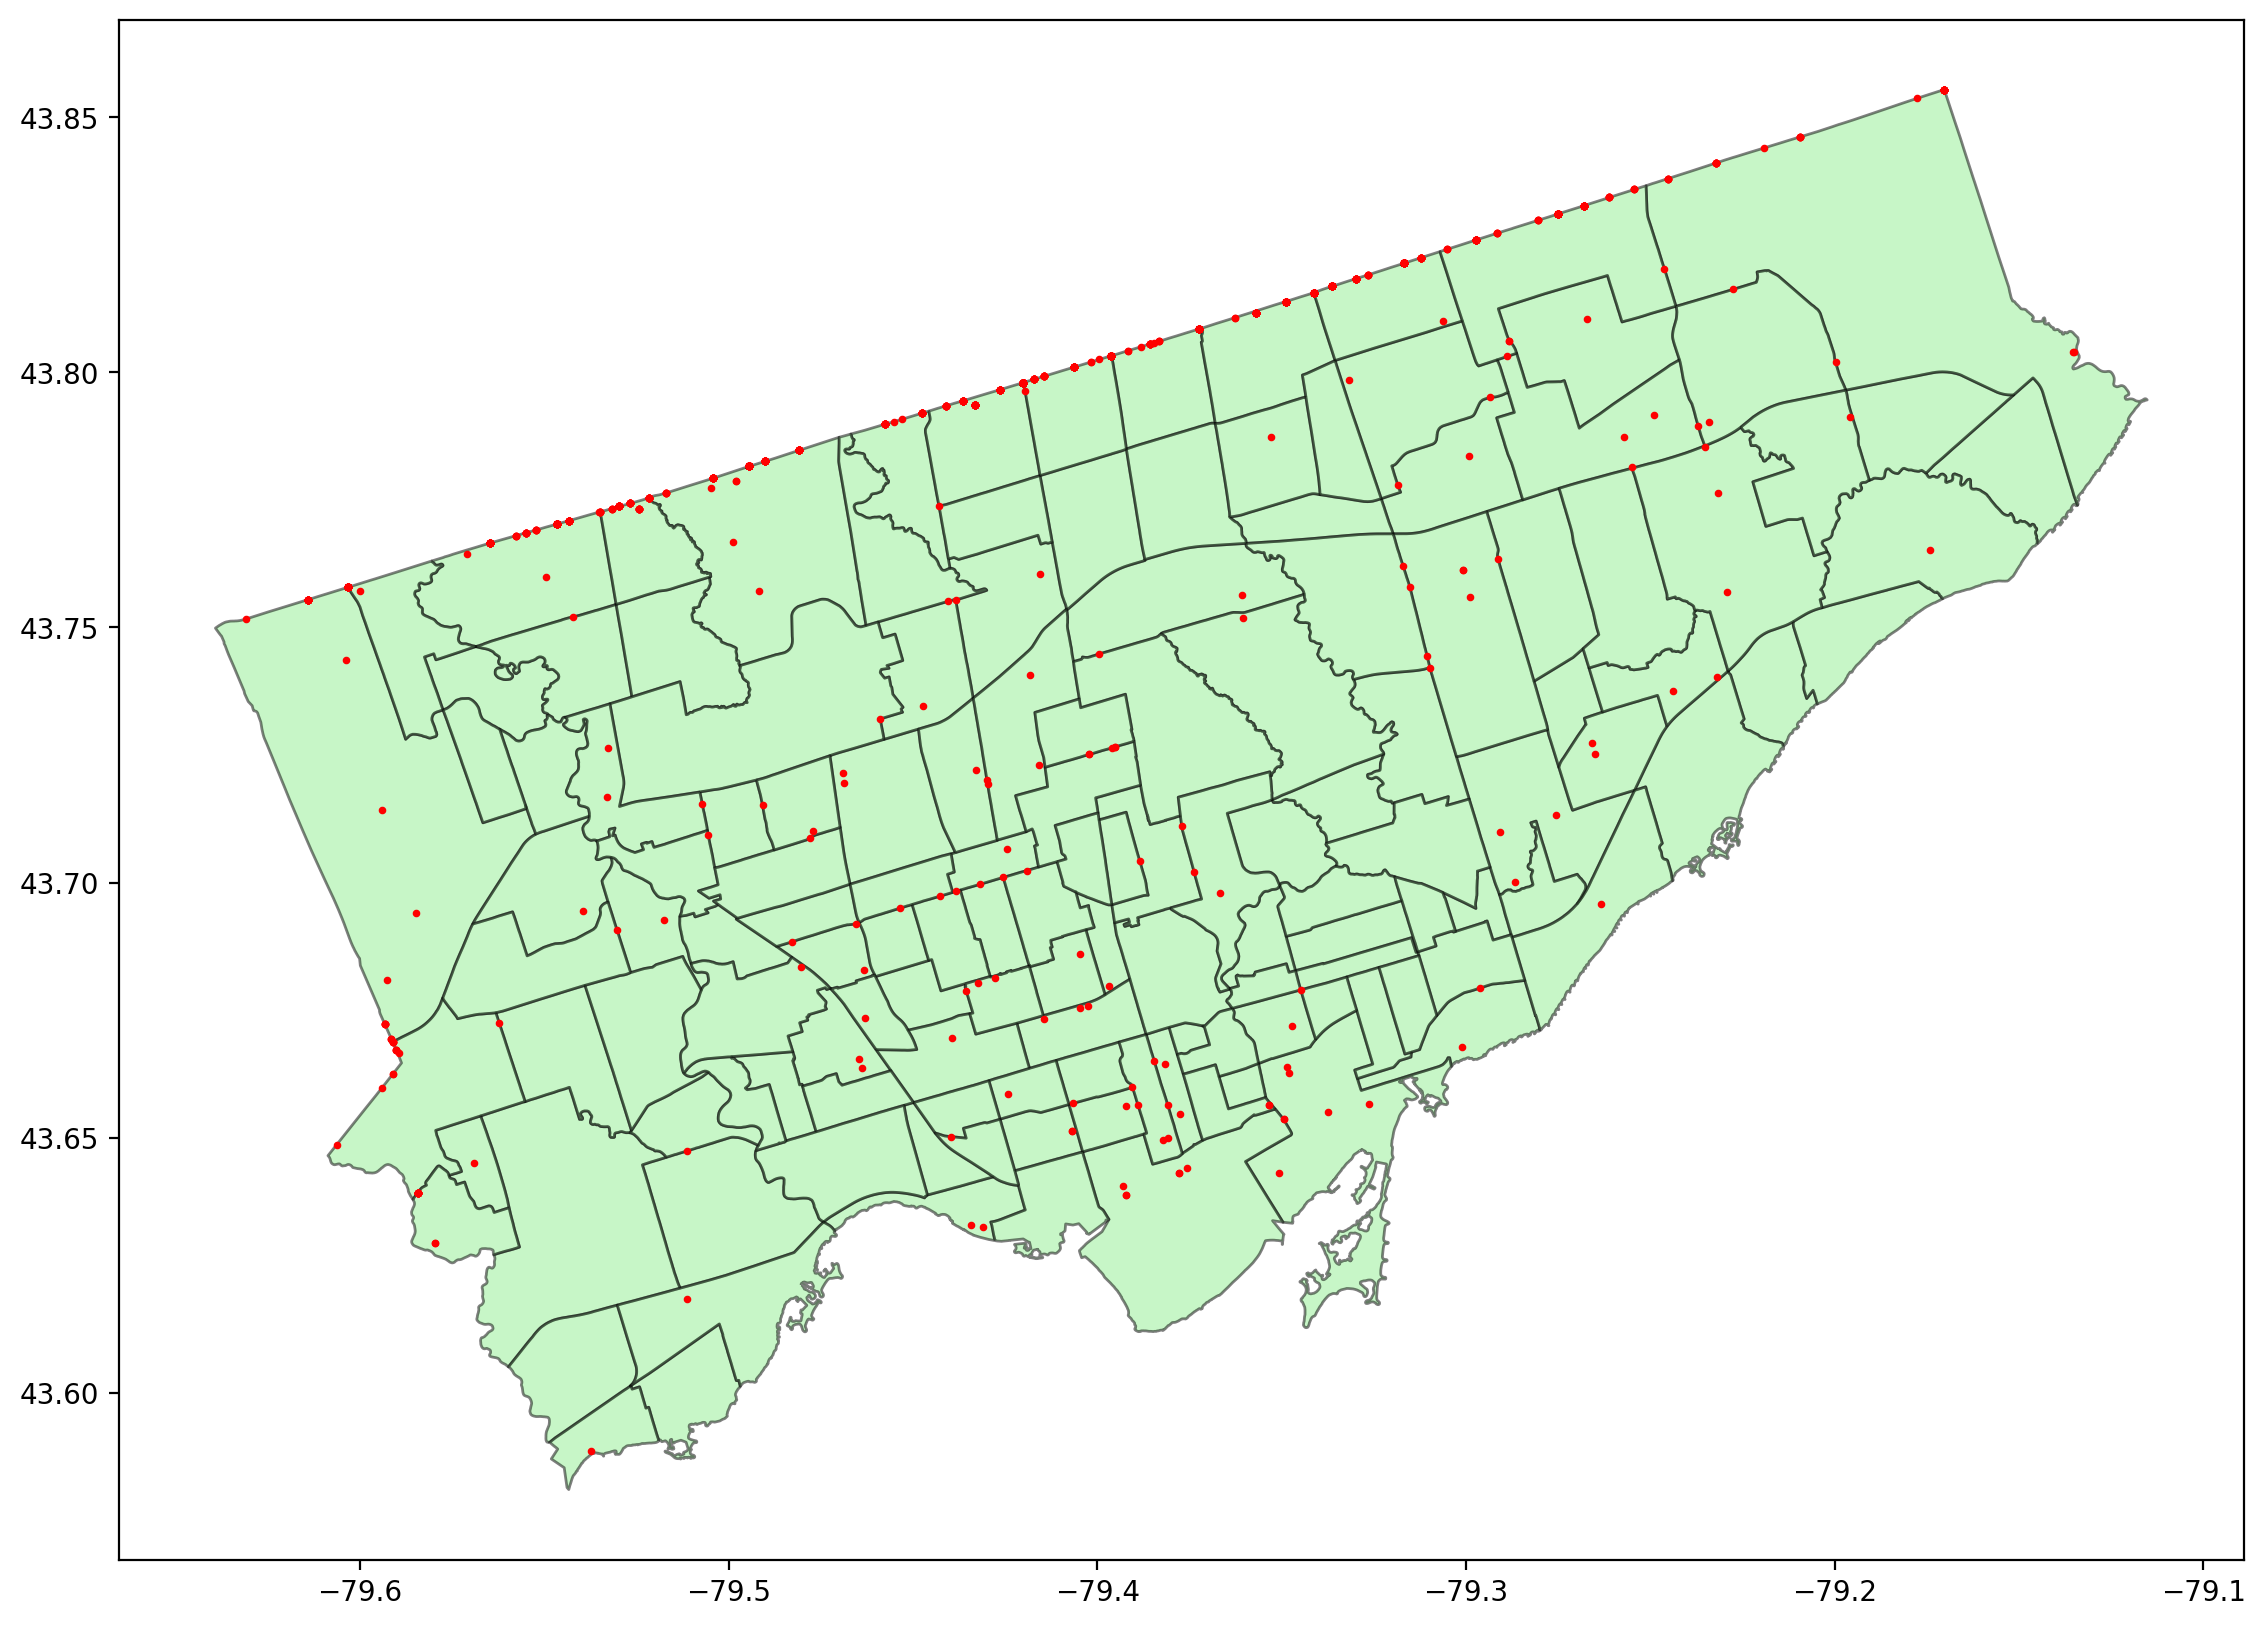

In [74]:
# check that we have correctly isolated only the locations within the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point.loc[NSA_within_neighbourhood.index].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

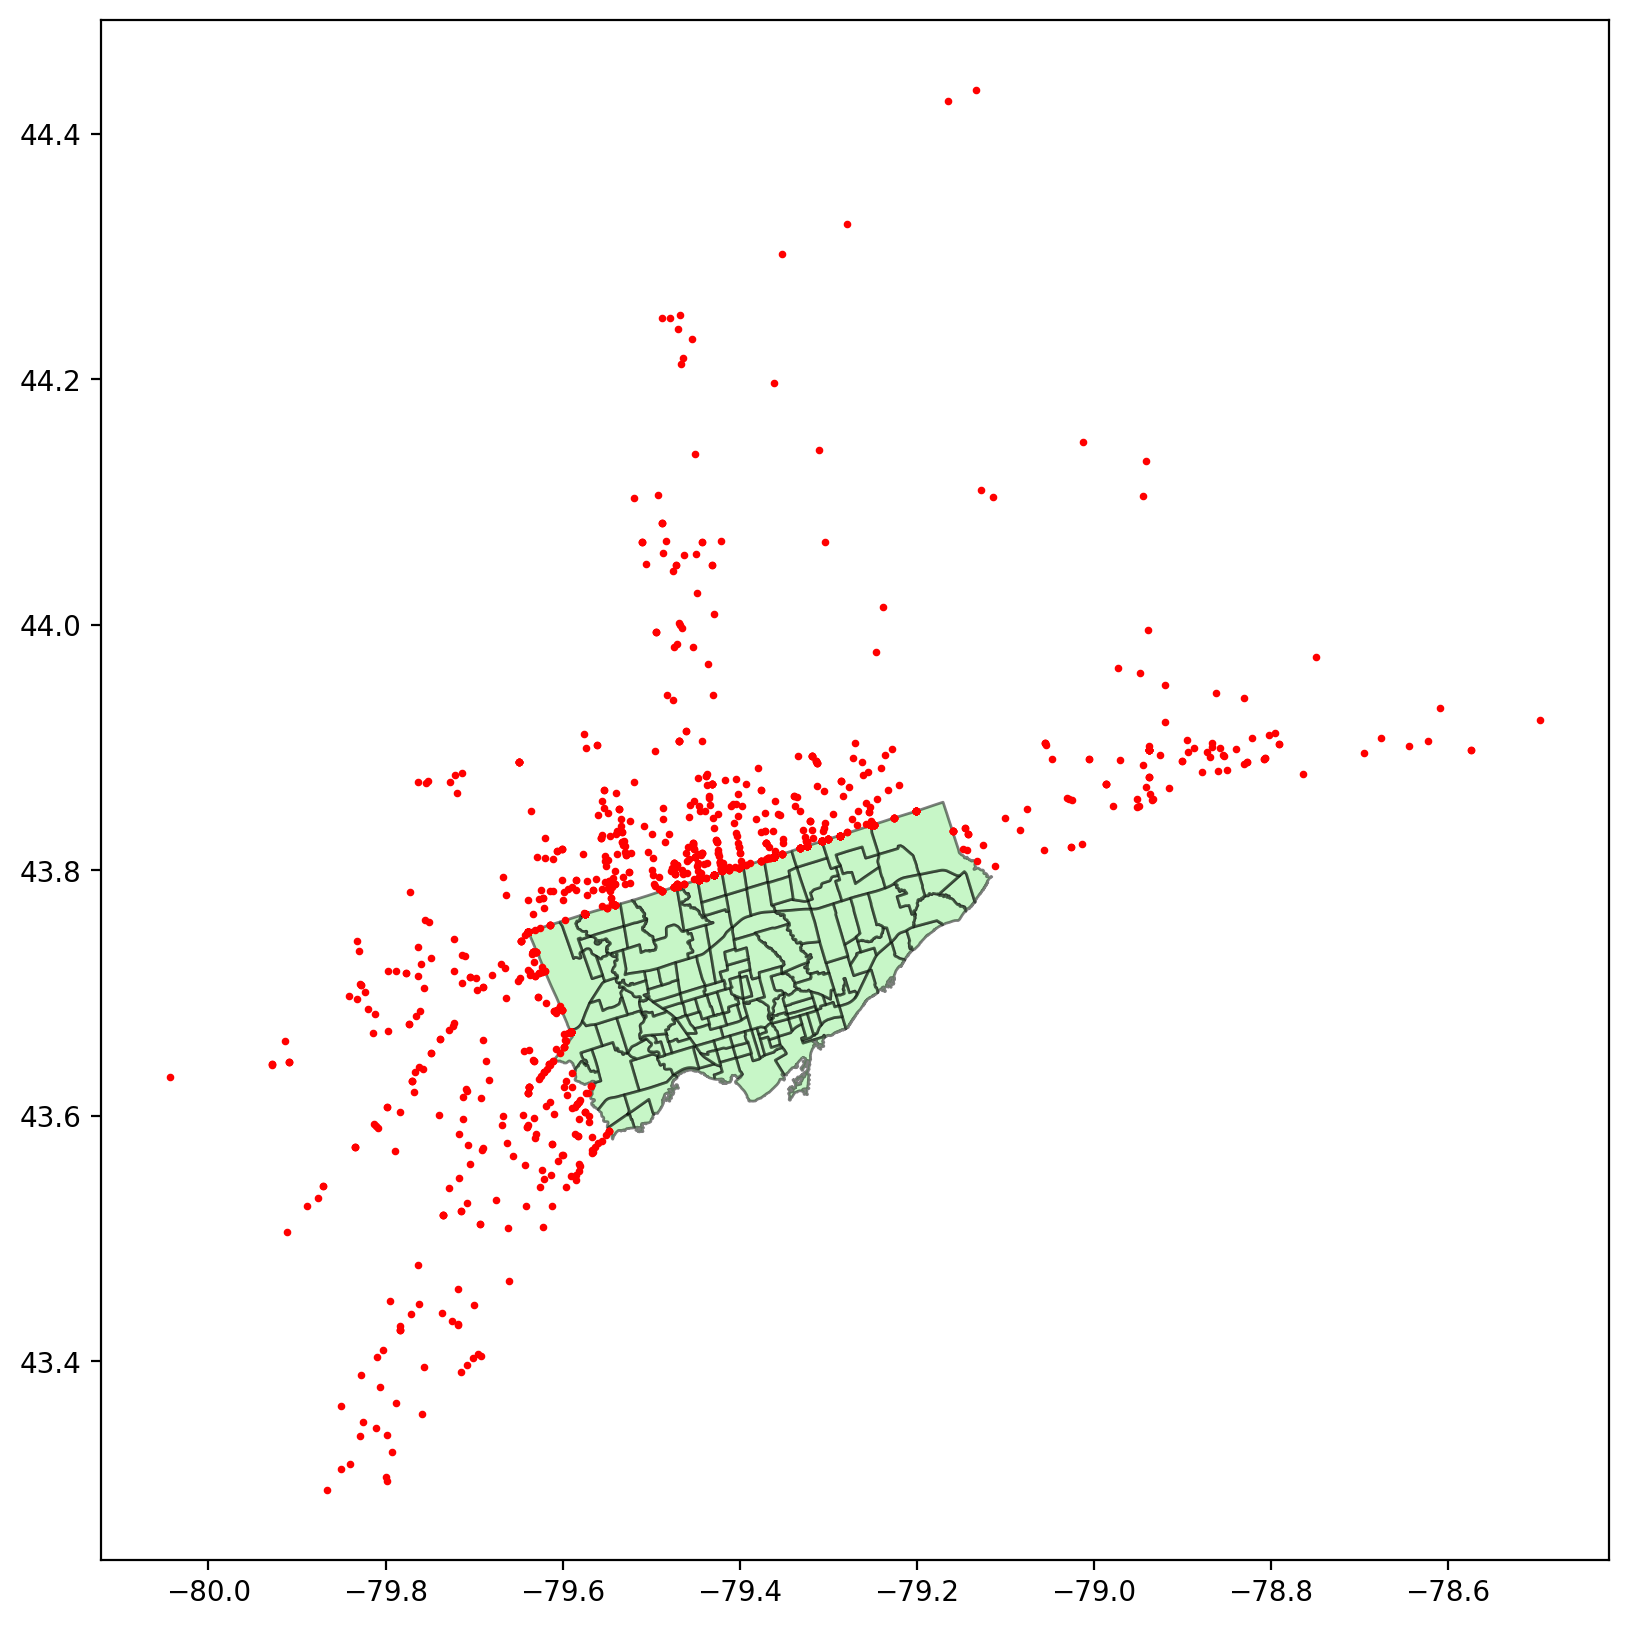

In [75]:
# check that now all the locations with neighbourhood as NSA are outside any out the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] == 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

<AxesSubplot:>

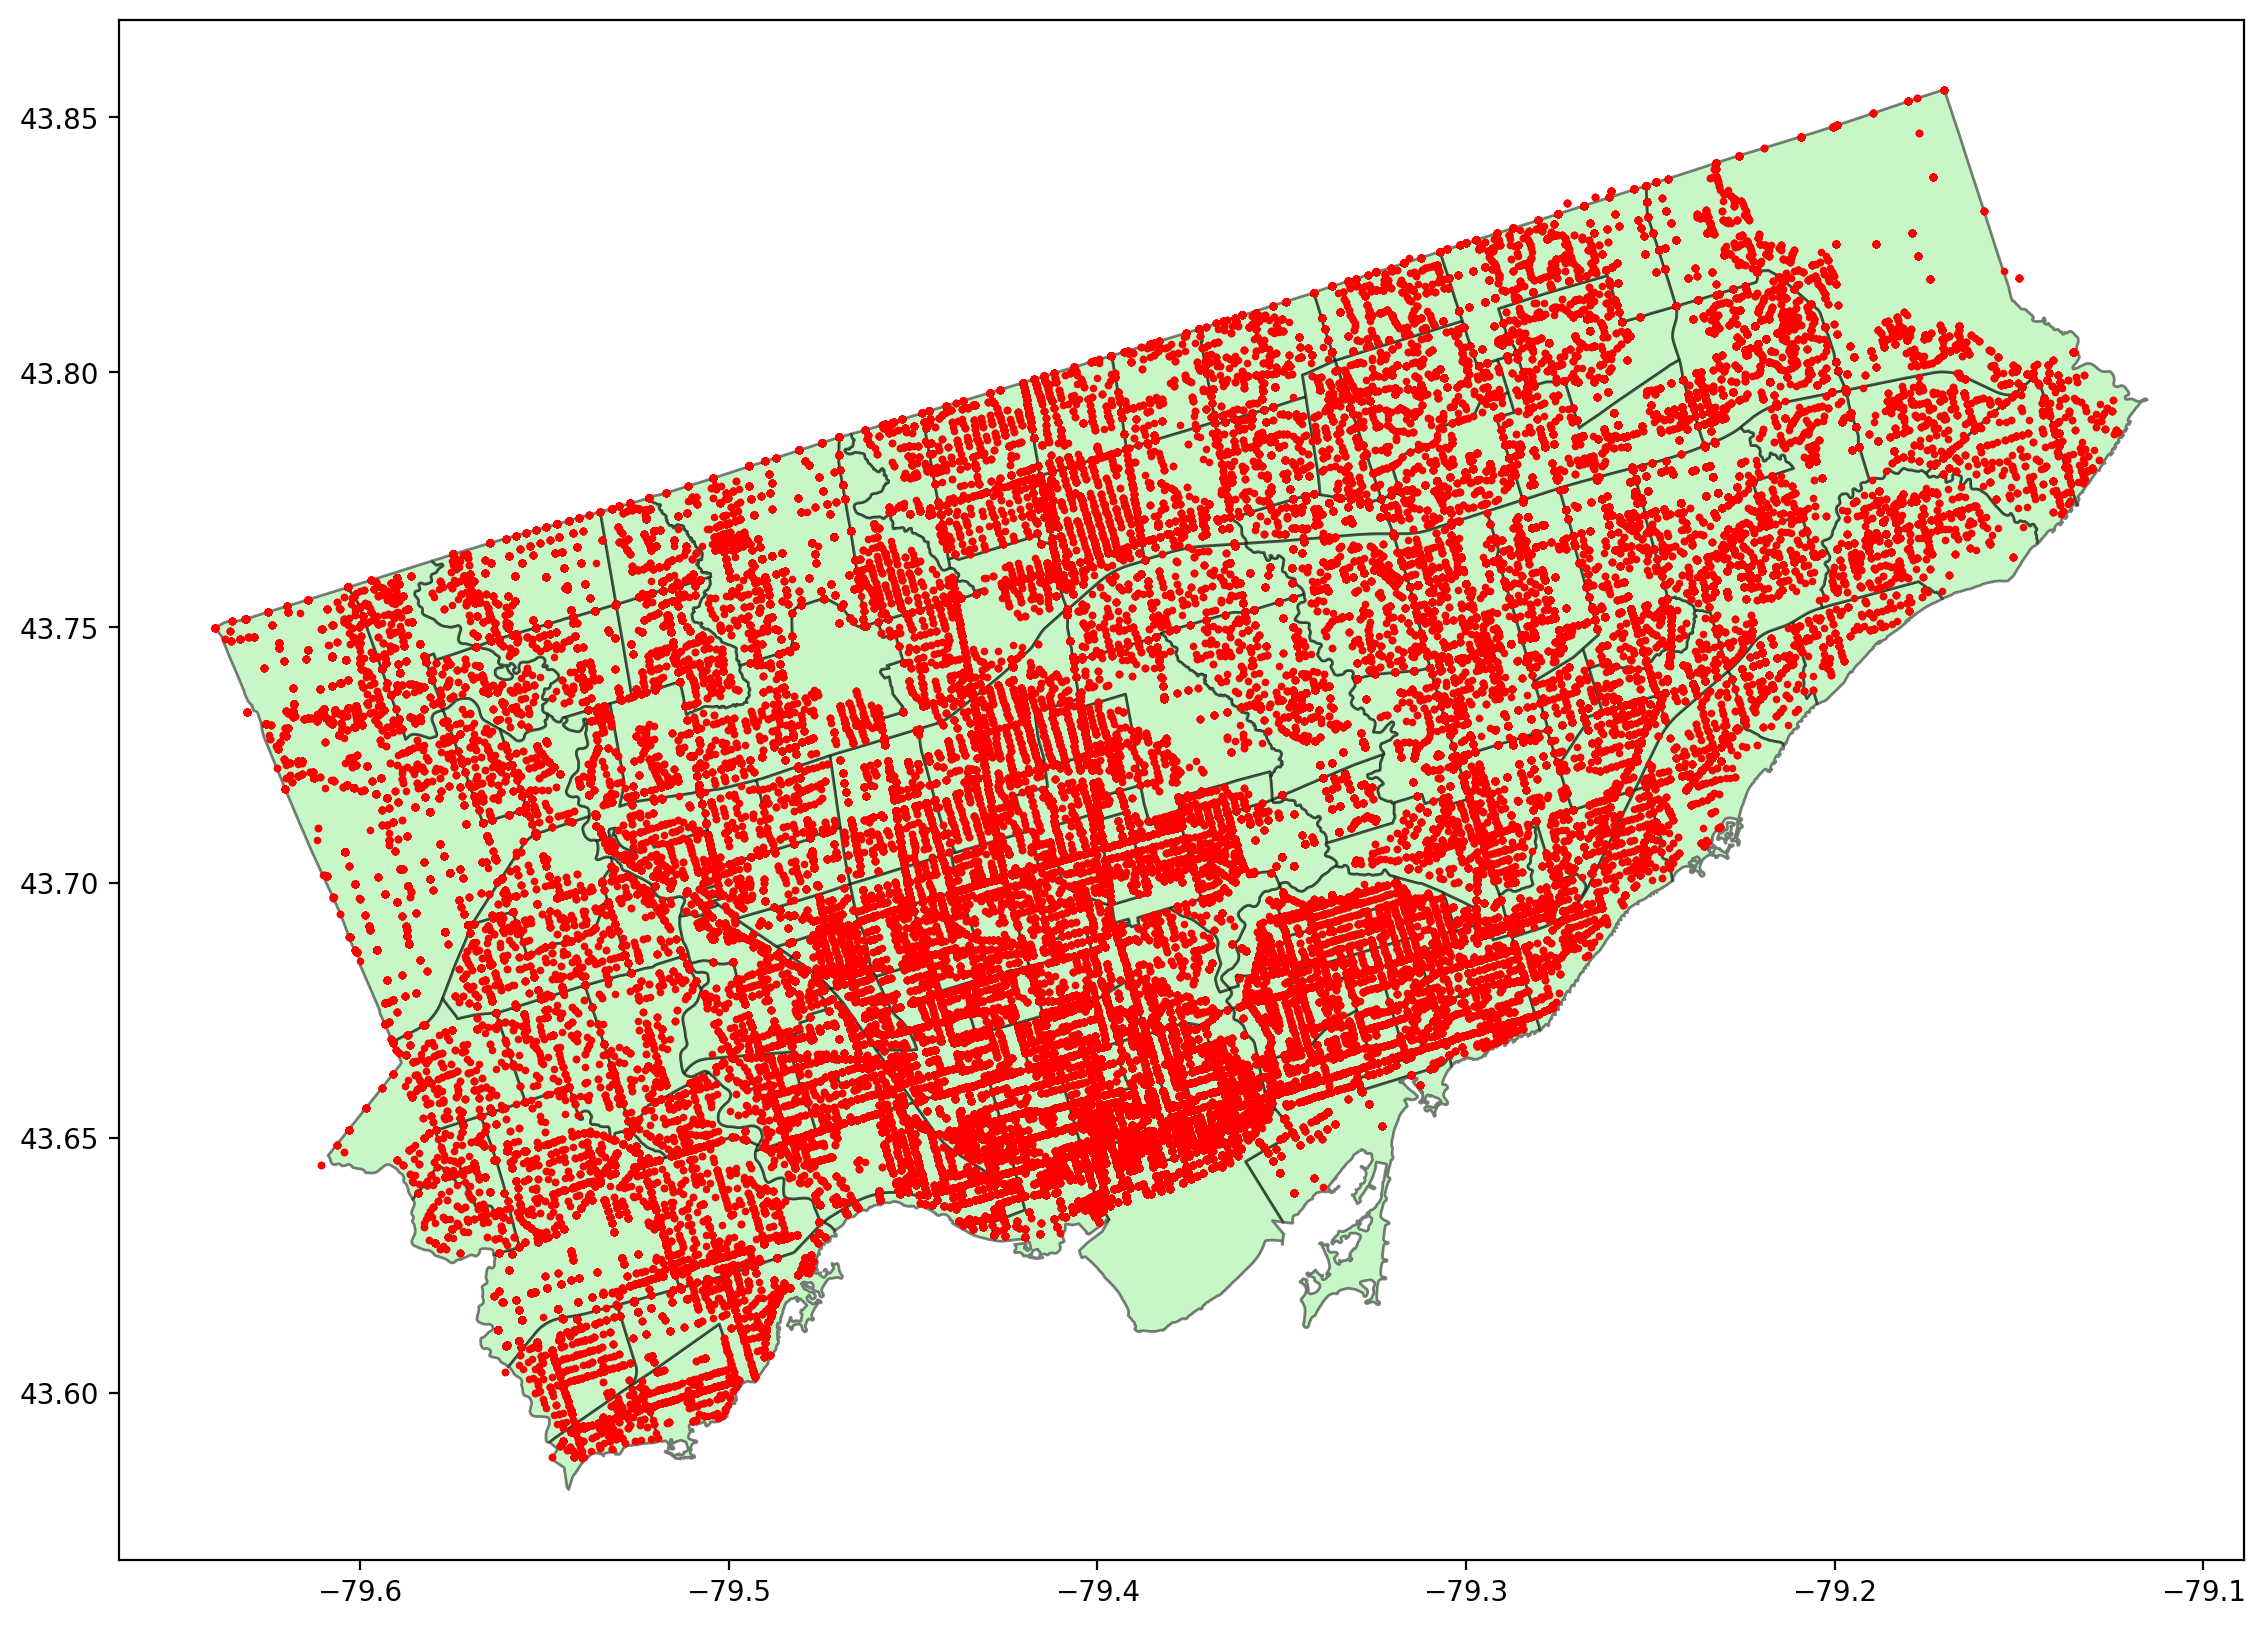

In [76]:
# now all the locations with neighbourhood not as NSA are inside the neighbourhoods
ax = neighbourhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
collision_point[collision_point['Neighbourhood'] != 'NSA'].plot(ax=ax, color = 'red', markersize = 3)

# Add Fatal_Collisions

In [83]:
collision_point['Fatal_Collisions'] = [1 if x != 0 else 0 for x in collision_point['Fatalities']]

# Output

In [84]:
collision_point

X             Y  ObjectId event_unique_id  \
0       0.000000e+00  0.000000e+00       278  GO-20141591056   
1       0.000000e+00  0.000000e+00      1246  GO-20143120578   
2       0.000000e+00  0.000000e+00     21564  GO-20168056919   
3       0.000000e+00  0.000000e+00     21709  GO-20168059092   
4       0.000000e+00  0.000000e+00     21277  GO-20168053844   
...              ...           ...       ...             ...   
430281 -8.865398e+06  5.426816e+06    499212  GO-20178006796   
430282 -8.865398e+06  5.426816e+06    499213  GO-20178007507   
430283 -8.865398e+06  5.426816e+06    499214  GO-20178008123   
430284 -8.865398e+06  5.426816e+06    499215  GO-20178014940   
430285 -8.865398e+06  5.426816e+06    499216  GO-20178020054   

                  occurrencedate occurrencemonth occurrencedayofweek  \
0      2014-02-24 17:00:00-04:00        February              Monday   
1      2014-10-17 09:00:00-04:00         October              Friday   
2      2016-12-17 09:00:00-04:00        December            Saturday   
3      2016-12-27 18:00:00-04:00        December             Tuesday   
4      2016-11-30 18:00:00-04:00        November           Wednesday   
...                          ...             ...                 ...   
430281 2017-02-14 14:00:00-04:00        February             Tuesday   
430282 2017-02-18 13:00:00-04:00        February            Saturday   
430283 2017-02-22 22:00:00-04:00        February           Wednesday   
430284 2017-04-07 14:00:00-04:00           April              Friday   
430285 2017-05-07 16:00:00-04:00             May              Sunday   

        occurrenceyear  occurrencehour Division            Neighbourhood  \
0                 2014              17      D32     St.Andrew-Windfields   
1                 2014               9      D31   Glenfield-Jane Heights   
2                 2016               9      D31  York University Heights   
3                 2016              18      D32       Yorkdale-Glen Park   
4                 2016              18      D33        Hillcrest Village   
...                ...             ...      ...                      ...   
430281            2017              14      NSA                      NSA   
430282            2017              13      NSA                      NSA   
430283            2017              22      D23   West Humber-Clairville   
430284            2017              14      NSA                      NSA   
430285            2017              16      NSA                      NSA   

        Fatalities  Injury_Collisions  FTR_Collisions  PD_Collisions  \
0                0                  0               1              0   
1                0                  0               0              1   
2                0                  0               0              1   
3                0                  0               1              0   
4                0                  0               0              1   
...            ...                ...             ...            ...   
430281           0                  0               0              1   
430282           0                  0               1              0   
430283           0                  0               0              1   
430284           0                  0               0              1   
430285           0                  0               0              1   

             Long        Lat  ObjectId2 hood_id  occurrenceday  \
0      -79.402034  43.748097        178      40           24.0   
1      -79.513544  43.743014       1046      25           17.0   
2      -79.498253  43.763907      21094      27           17.0   
3      -79.459962  43.707040      21162      31           27.0   
4      -79.352088  43.807805      21340      48           30.0   
...           ...        ...        ...     ...            ...   
430281 -79.639225  43.749873     499534     NSA           14.0   
430282 -79.639225  43.749873     499535     NSA           18.0   
430283 -79.63

In [85]:
# output file to clean_data folder
# csv instead of geojson due to size
collision_point.to_csv('./clean_data/collision_point.csv', index=False)

# Aggregate traffic collsions by neighbourhood after 2014

<AxesSubplot:xlabel='occurrenceyear'>

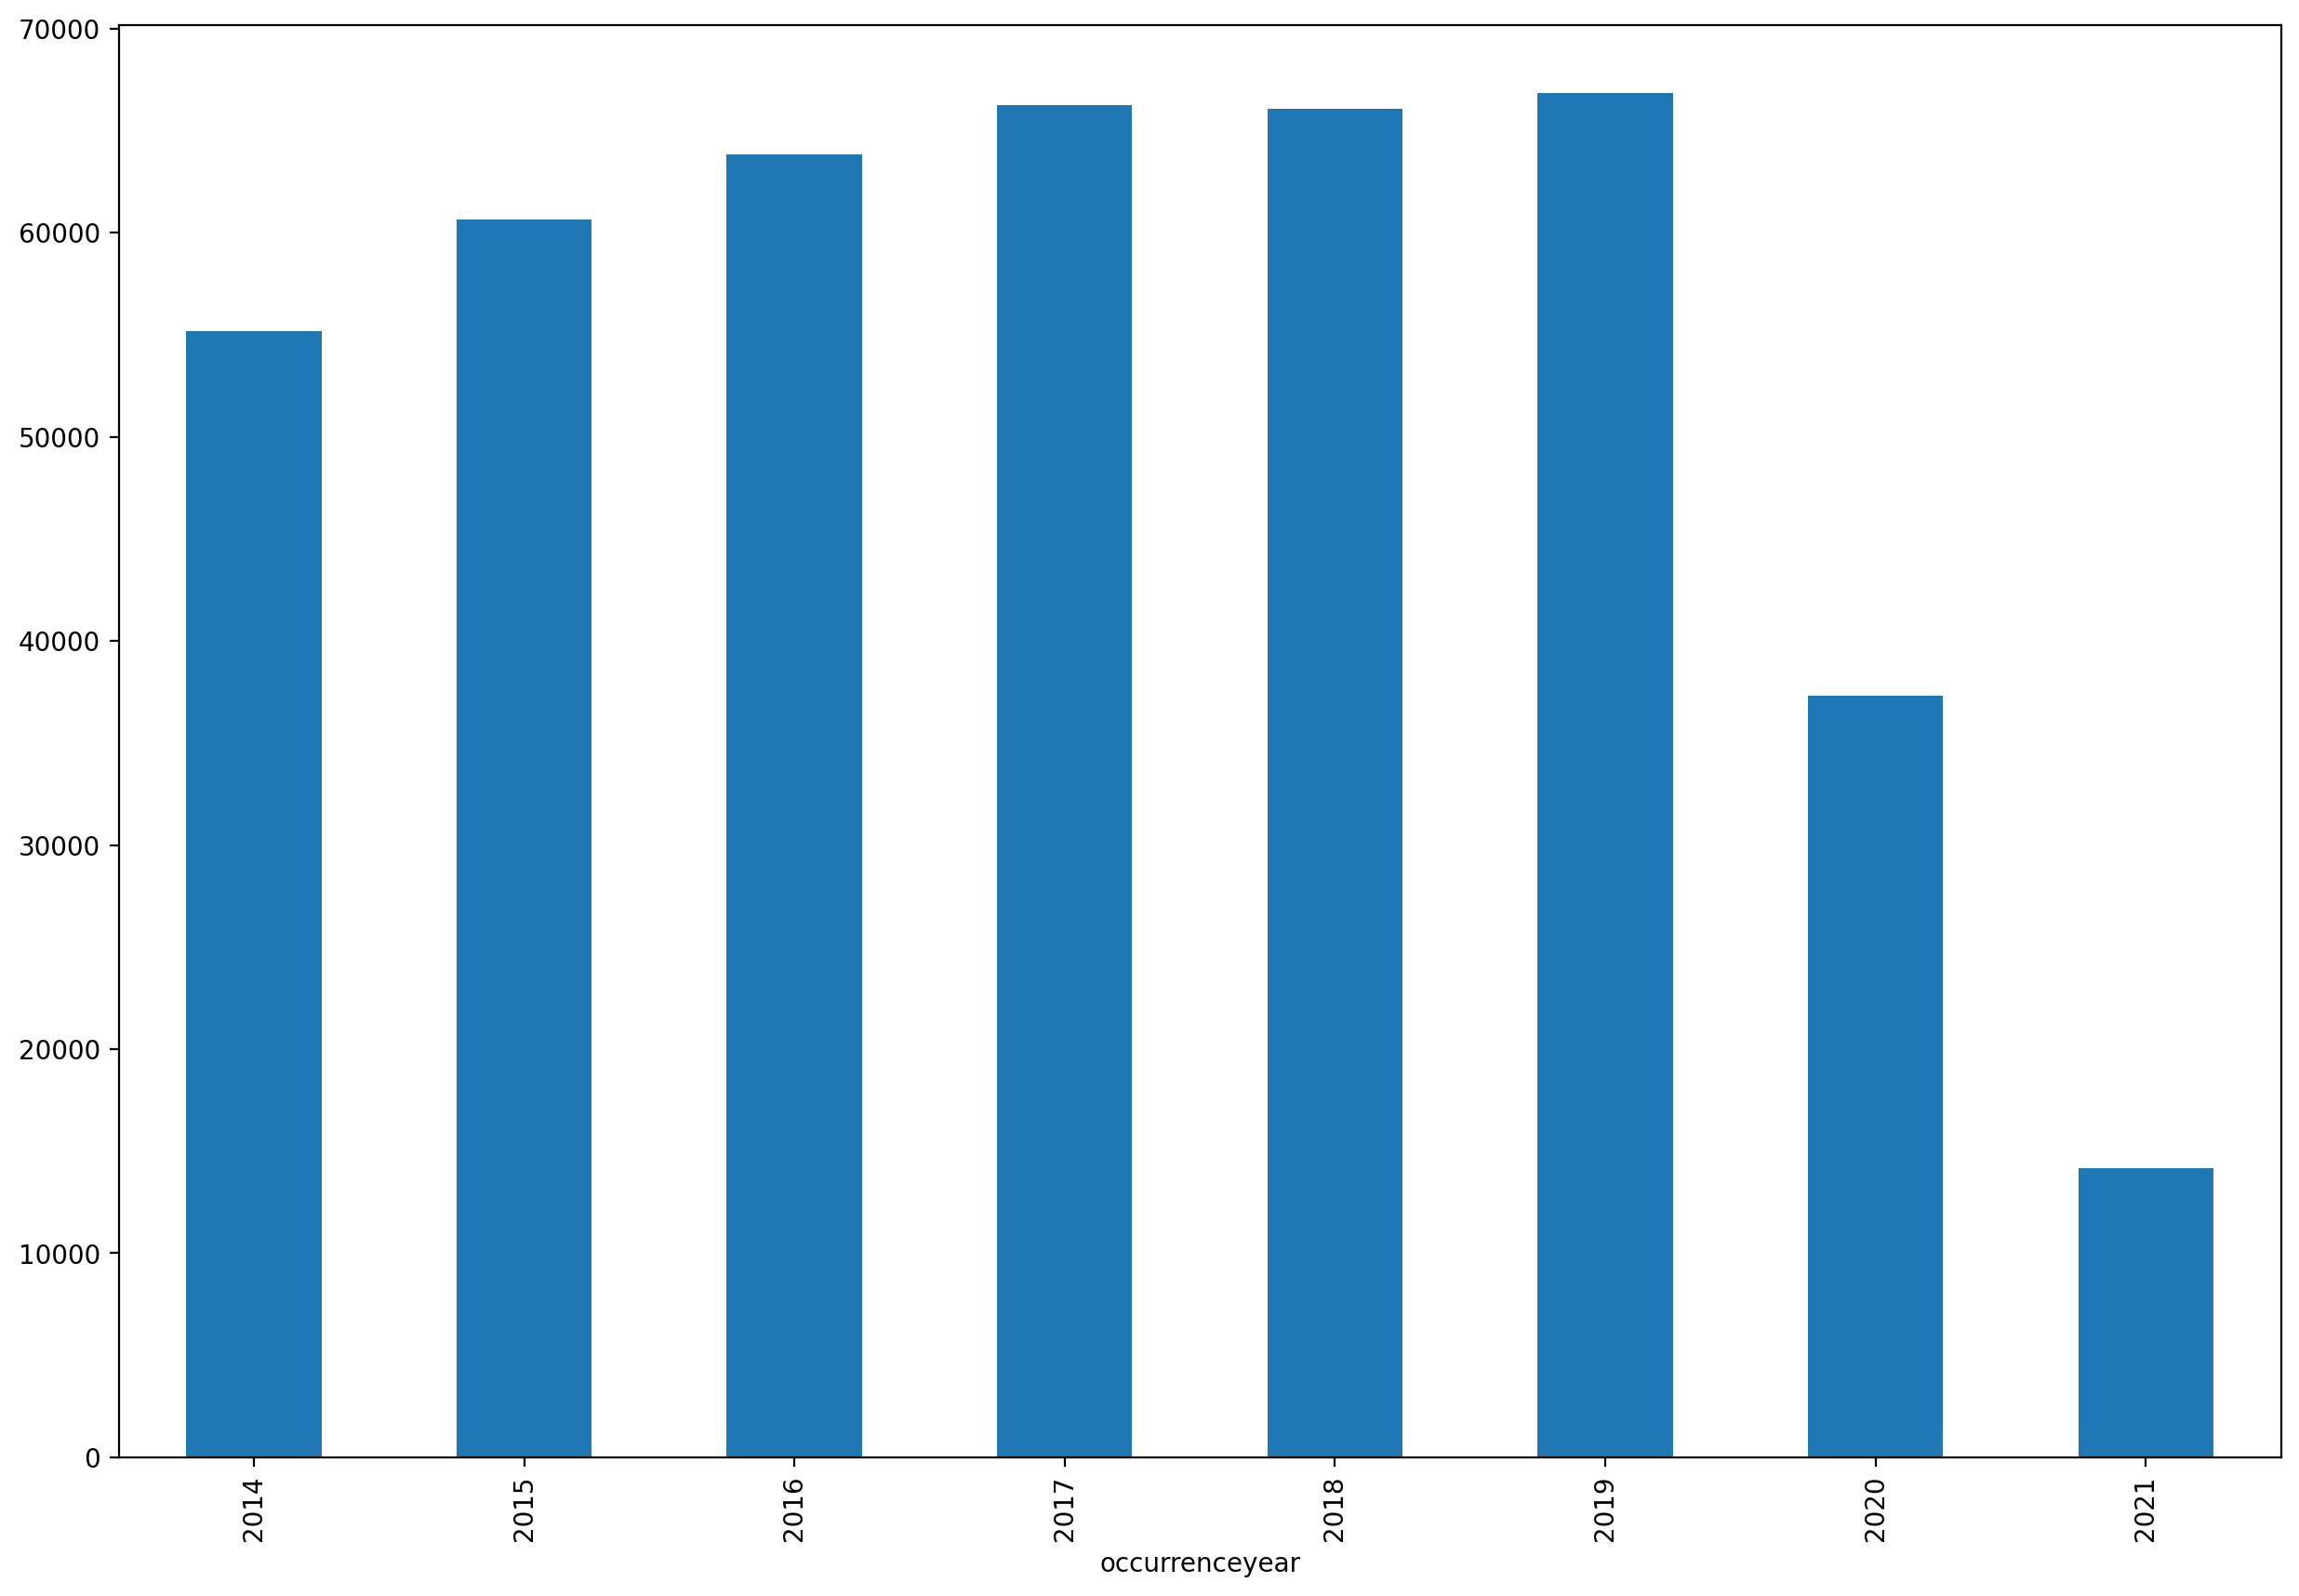

In [86]:
# There is limited data for crimes which happened before 2014
collision_point.groupby("occurrenceyear").size().plot(kind="bar")

In [87]:
collision_point

X             Y  ObjectId event_unique_id  \
0       0.000000e+00  0.000000e+00       278  GO-20141591056   
1       0.000000e+00  0.000000e+00      1246  GO-20143120578   
2       0.000000e+00  0.000000e+00     21564  GO-20168056919   
3       0.000000e+00  0.000000e+00     21709  GO-20168059092   
4       0.000000e+00  0.000000e+00     21277  GO-20168053844   
...              ...           ...       ...             ...   
430281 -8.865398e+06  5.426816e+06    499212  GO-20178006796   
430282 -8.865398e+06  5.426816e+06    499213  GO-20178007507   
430283 -8.865398e+06  5.426816e+06    499214  GO-20178008123   
430284 -8.865398e+06  5.426816e+06    499215  GO-20178014940   
430285 -8.865398e+06  5.426816e+06    499216  GO-20178020054   

                  occurrencedate occurrencemonth occurrencedayofweek  \
0      2014-02-24 17:00:00-04:00        February              Monday   
1      2014-10-17 09:00:00-04:00         October              Friday   
2      2016-12-17 09:00:00-04:00        December            Saturday   
3      2016-12-27 18:00:00-04:00        December             Tuesday   
4      2016-11-30 18:00:00-04:00        November           Wednesday   
...                          ...             ...                 ...   
430281 2017-02-14 14:00:00-04:00        February             Tuesday   
430282 2017-02-18 13:00:00-04:00        February            Saturday   
430283 2017-02-22 22:00:00-04:00        February           Wednesday   
430284 2017-04-07 14:00:00-04:00           April              Friday   
430285 2017-05-07 16:00:00-04:00             May              Sunday   

        occurrenceyear  occurrencehour Division            Neighbourhood  \
0                 2014              17      D32     St.Andrew-Windfields   
1                 2014               9      D31   Glenfield-Jane Heights   
2                 2016               9      D31  York University Heights   
3                 2016              18      D32       Yorkdale-Glen Park   
4                 2016              18      D33        Hillcrest Village   
...                ...             ...      ...                      ...   
430281            2017              14      NSA                      NSA   
430282            2017              13      NSA                      NSA   
430283            2017              22      D23   West Humber-Clairville   
430284            2017              14      NSA                      NSA   
430285            2017              16      NSA                      NSA   

        Fatalities  Injury_Collisions  FTR_Collisions  PD_Collisions  \
0                0                  0               1              0   
1                0                  0               0              1   
2                0                  0               0              1   
3                0                  0               1              0   
4                0                  0               0              1   
...            ...                ...             ...            ...   
430281           0                  0               0              1   
430282           0                  0               1              0   
430283           0                  0               0              1   
430284           0                  0               0              1   
430285           0                  0               0              1   

             Long        Lat  ObjectId2 hood_id  occurrenceday  \
0      -79.402034  43.748097        178      40           24.0   
1      -79.513544  43.743014       1046      25           17.0   
2      -79.498253  43.763907      21094      27           17.0   
3      -79.459962  43.707040      21162      31           27.0   
4      -79.352088  43.807805      21340      48           30.0   
...           ...        ...        ...     ...            ...   
430281 -79.639225  43.749873     499534     NSA           14.0   
430282 -79.639225  43.749873     499535     NSA           18.0   
430283 -79.63

In [88]:
# filter out data before 2014 and marked as NSA (outside City of Toronto)
collision_groupby = collision_point[collision_point.Neighbourhood != "NSA"].groupby(["Neighbourhood", "hood_id", "occurrenceyear"]).agg({"event_unique_id": "count",
                                                                                                                                         "Fatal_Collisions": "sum",
                                                                                                                                         "Injury_Collisions": "sum",
                                                                                                                                         "FTR_Collisions": "sum",
                                                                                                                                         "PD_Collisions": "sum"}).reset_index()
collision_groupby.rename(columns={"event_unique_id": "Collision"}, inplace=True)
collision_groupby = collision_groupby.melt(id_vars=["Neighbourhood", "hood_id", "occurrenceyear"],
                                           var_name="Type",
                                           value_name="count")
collision_groupby

Neighbourhood hood_id  occurrenceyear           Type  count
0        Agincourt North     129            2014      Collision    483
1        Agincourt North     129            2015      Collision    548
2        Agincourt North     129            2016      Collision    514
3        Agincourt North     129            2017      Collision    546
4        Agincourt North     129            2018      Collision    567
...                  ...     ...             ...            ...    ...
5595  Yorkdale-Glen Park      31            2017  PD_Collisions    627
5596  Yorkdale-Glen Park      31            2018  PD_Collisions    595
5597  Yorkdale-Glen Park      31            2019  PD_Collisions    741
5598  Yorkdale-Glen Park      31            2020  PD_Collisions    389
5599  Yorkdale-Glen Park      31            2021  PD_Collisions    135

[5600 rows x 5 columns]

In [89]:
collision_groupby.occurrenceyear.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=int64)

In [90]:
neighbourhood_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods.columns if re.search('\d+', x) is not None])))
neighbourhood_years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [91]:
neighbourhoods_select = neighbourhoods[['Neighbourhood', 'hood_id'] + 
                                       ['Population_' + x for x in neighbourhood_years] + 
                                       ['geometry']]

In [92]:
# extrapolate population in 2021 based on population growth rate from 2019 to 2020
neighbourhoods_select['Population_2021'] = (neighbourhoods_select['Population_2020'] * neighbourhoods_select['Population_2020'] / neighbourhoods_select['Population_2019']).values

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [93]:
neighbourhoods_select['area'] = neighbourhoods_select.to_crs(epsg_2d).geometry.area / 10**6
neighbourhoods_select.drop(columns = 'geometry', inplace = True)

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\AppData\Local\Temp\ipykernel_20216\1820593773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbourhoods_select.drop(columns = 'geometry', inplace = True)


In [94]:
neighbourhoods_select = pd.wide_to_long(neighbourhoods_select, stubnames='Population', 
                                        i=['Neighbourhood', 'hood_id'], 
                                        j='occurrenceyear', sep='_').reset_index()
neighbourhoods_select

Neighbourhood hood_id  occurrenceyear      area  \
0                          Yonge-St.Clair      97            2014  1.161318   
1                          Yonge-St.Clair      97            2015  1.161318   
2                          Yonge-St.Clair      97            2016  1.161318   
3                          Yonge-St.Clair      97            2017  1.161318   
4                          Yonge-St.Clair      97            2018  1.161318   
...                                   ...     ...             ...       ...   
1115  Mimico (includes Humber Bay Shores)      17            2017  7.059185   
1116  Mimico (includes Humber Bay Shores)      17            2018  7.059185   
1117  Mimico (includes Humber Bay Shores)      17            2019  7.059185   
1118  Mimico (includes Humber Bay Shores)      17            2020  7.059185   
1119  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

        Population  
0     12597.000000  
1     12746.000000  
2     12950.000000  
3     13214.000000  
4     13508.000000  
...            ...  
1115  36043.000000  
1116  31671.000000  
1117  37839.000000  
1118  38738.000000  
1119  39658.358942  

[1120 rows x 5 columns]

In [95]:
collision_groupby

Neighbourhood hood_id  occurrenceyear           Type  count
0        Agincourt North     129            2014      Collision    483
1        Agincourt North     129            2015      Collision    548
2        Agincourt North     129            2016      Collision    514
3        Agincourt North     129            2017      Collision    546
4        Agincourt North     129            2018      Collision    567
...                  ...     ...             ...            ...    ...
5595  Yorkdale-Glen Park      31            2017  PD_Collisions    627
5596  Yorkdale-Glen Park      31            2018  PD_Collisions    595
5597  Yorkdale-Glen Park      31            2019  PD_Collisions    741
5598  Yorkdale-Glen Park      31            2020  PD_Collisions    389
5599  Yorkdale-Glen Park      31            2021  PD_Collisions    135

[5600 rows x 5 columns]

In [96]:
collision_merge = neighbourhoods_select.merge(collision_groupby, how='outer', on=['Neighbourhood', 'hood_id', 'occurrenceyear'])
collision_merge

Neighbourhood hood_id  occurrenceyear      area  \
0                          Yonge-St.Clair      97            2014  1.161318   
1                          Yonge-St.Clair      97            2014  1.161318   
2                          Yonge-St.Clair      97            2014  1.161318   
3                          Yonge-St.Clair      97            2014  1.161318   
4                          Yonge-St.Clair      97            2014  1.161318   
...                                   ...     ...             ...       ...   
5595  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5596  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5597  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5598  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5599  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

        Population               Type  count  
0     12597.000000          Collision    238  
1     12597.000000   Fatal_Collisions      1  
2     12597.000000  Injury_Collisions     21  
3     12597.000000     FTR_Collisions     32  
4     12597.000000      PD_Collisions    184  
...            ...                ...    ...  
5595  39658.358942          Collision    178  
5596  39658.358942   Fatal_Collisions      0  
5597  39658.358942  Injury_Collisions     30  
5598  39658.358942     FTR_Collisions     30  
5599  39658.358942      PD_Collisions    134  

[5600 rows x 7 columns]

In [97]:
collision_merge.isna().sum()

Neighbourhood     0
hood_id           0
occurrenceyear    0
area              0
Population        0
Type              0
count             0
dtype: int64

In [98]:
# rate: number of collisions per 100k people
collision_merge['rate'] = collision_merge['count'] / collision_merge['Population'] * 10**5
# density: number of collisions per 1km^2
collision_merge['density'] = collision_merge['count'] / collision_merge['area']

In [99]:
collision_merge

Neighbourhood hood_id  occurrenceyear      area  \
0                          Yonge-St.Clair      97            2014  1.161318   
1                          Yonge-St.Clair      97            2014  1.161318   
2                          Yonge-St.Clair      97            2014  1.161318   
3                          Yonge-St.Clair      97            2014  1.161318   
4                          Yonge-St.Clair      97            2014  1.161318   
...                                   ...     ...             ...       ...   
5595  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5596  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5597  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5598  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
5599  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

        Population               Type  count         rate     density  
0     12597.000000          Collision    238  1889.338731  204.939633  
1     12597.000000   Fatal_Collisions      1     7.938398    0.861091  
2     12597.000000  Injury_Collisions     21   166.706359   18.082909  
3     12597.000000     FTR_Collisions     32   254.028737   27.554909  
4     12597.000000      PD_Collisions    184  1460.665238  158.440725  
...            ...                ...    ...          ...         ...  
5595  39658.358942          Collision    178   448.833499   25.215375  
5596  39658.358942   Fatal_Collisions      0     0.000000    0.000000  
5597  39658.358942  Injury_Collisions     30    75.646095    4.249782  
5598  39658.358942     FTR_Collisions     30    75.646095    4.249782  
5599  39658.358942      PD_Collisions    134   337.885892   18.982361  

[5600 rows x 9 columns]

In [100]:
collision_melt = collision_merge.melt(id_vars=['Neighbourhood', 'hood_id', 'occurrenceyear', 'area', 'Population', 'Type'],
                                      value_vars=['count', 'rate', 'density'],
                                      var_name='type',
                                      value_name='value')
collision_melt

Neighbourhood hood_id  occurrenceyear      area  \
0                           Yonge-St.Clair      97            2014  1.161318   
1                           Yonge-St.Clair      97            2014  1.161318   
2                           Yonge-St.Clair      97            2014  1.161318   
3                           Yonge-St.Clair      97            2014  1.161318   
4                           Yonge-St.Clair      97            2014  1.161318   
...                                    ...     ...             ...       ...   
16795  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
16796  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
16797  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
16798  Mimico (includes Humber Bay Shores)      17            2021  7.059185   
16799  Mimico (includes Humber Bay Shores)      17            2021  7.059185   

         Population               Type     type       value  
0      12597.000000          Collision    count  238.000000  
1      12597.000000   Fatal_Collisions    count    1.000000  
2      12597.000000  Injury_Collisions    count   21.000000  
3      12597.000000     FTR_Collisions    count   32.000000  
4      12597.000000      PD_Collisions    count  184.000000  
...             ...                ...      ...         ...  
16795  39658.358942          Collision  density   25.215375  
16796  39658.358942   Fatal_Collisions  density    0.000000  
16797  39658.358942  Injury_Collisions  density    4.249782  
16798  39658.358942     FTR_Collisions  density    4.249782  
16799  39658.358942      PD_Collisions  density   18.982361  

[16800 rows x 8 columns]

In [101]:
collision_melt['Collision_Typeyear'] = collision_melt['Type'].apply(lambda x: x.title().replace('_', '')) + "_" + collision_melt['type'].str.title() + collision_melt['occurrenceyear'].astype(str)

In [102]:
collision_pivot = collision_melt.pivot(index=['Neighbourhood', 'hood_id'], columns=['Collision_Typeyear'], values=['value'])

In [103]:
collision_pivot.columns = collision_pivot.columns.droplevel(0)

In [104]:
collision_pivot = collision_pivot.reset_index()

In [105]:
collision_pivot

Collision_Typeyear                 Neighbourhood hood_id  Collision_Count2014  \
0                                Agincourt North     129                483.0   
1                   Agincourt South-Malvern West     128                830.0   
2                                      Alderwood      20                130.0   
3                                          Annex      95                938.0   
4                              Banbury-Don Mills      42               1017.0   
..                                           ...     ...                  ...   
135                                     Wychwood      94                200.0   
136                               Yonge-Eglinton     100                354.0   
137                               Yonge-St.Clair      97                238.0   
138                      York University Heights      27               1277.0   
139                           Yorkdale-Glen Park      31                943.0   

Collision_Typeyear  Collision_Count2015  Collision_Count2016  \
0                                 548.0                514.0   
1                                 929.0                909.0   
2                                 161.0                189.0   
3                                 903.0               1045.0   
4                                1460.0               1301.0   
..                                  ...                  ...   
135                               221.0                250.0   
136                               372.0                431.0   
137                               275.0                288.0   
138                              1374.0               1422.0   
139                               952.0               1001.0   

Collision_Typeyear  Collision_Count2017  Collision_Count2018  \
0                                 546.0                567.0   
1                                 947.0                913.0   
2                                 161.0                204.0   
3                                1003.0               1046.0   
4                                1316.0               1101.0   
..                                  ...                  ...   
135                               291.0                248.0   
136                               398.0                386.0   
137                               305.0                301.0   
138                              1400.0               1374.0   
139                              1001.0                928.0   

Collision_Typeyear  Collision_Count2019  Collision_Count2020  \
0                                 571.0                286.0   
1                                 958.0                480.0   
2                                 175.0                105.0   
3                                1045.0                563.0   
4                                1118.0                541.0   
..                                  ...                  ...   
135                               291.0                139.0   
136                               373.0                175.0   
137                               315.0                191.0   
138                              1432.0                840.0   
139                               944.0                480.0   

Collision_Typeyear  Collision_Count2021  Collision_Density2014  \
0                                  95.0              66.512223   
1                                 144.0             105.421552   
2                                  46.0              26.112065   
3                                 217.0             336.155213   
4                                 198.0             101.280906   
..                                  ...                    ...   
135                                54.0             118.893520   
136                                70.0             214.489196   
137                                68.0             204.939633   
138                               292.0              96.4010

In [106]:
# Missing data: number of neighbourhoods which have no data for a particular MCI type in a particular year
pd.DataFrame(collision_pivot.isna().sum()[collision_pivot.isna().sum() != 0].sort_values(ascending=False)).T

Empty DataFrame
Columns: []
Index: [0]

In [107]:
neighbourhood_collision = neighbourhoods[['Neighbourhood', 'hood_id', 'district', 'distance_km', 'geometry']].merge(collision_pivot.fillna(0), how='outer', on=['Neighbourhood', 'hood_id'])
neighbourhood_collision

Neighbourhood hood_id district  distance_km  \
0                         Yonge-St.Clair      97      C02     2.791462   
1                York University Heights      27      W05    13.676191   
2                       Lansing-Westgate      38      C07    10.427749   
3                     Yorkdale-Glen Park      31      W04     7.592207   
4                    Stonegate-Queensway      16      W07     9.017845   
..                                   ...     ...      ...          ...   
135                        Pleasant View      46      C15    14.643244   
136                             Wychwood      94      C02     2.864021   
137                   Leaside-Bennington      56      C11     5.149543   
138                 Briar Hill-Belgravia     108      W04     6.111904   
139  Mimico (includes Humber Bay Shores)      17      W06     9.894878   

                                              geometry  Collision_Count2014  \
0    POLYGON ((-79.39115 43.68108, -79.39137 43.680...                238.0   
1    POLYGON ((-79.50525 43.75987, -79.50484 43.759...               1277.0   
2    POLYGON ((-79.43994 43.76156, -79.44000 43.761...                362.0   
3    POLYGON ((-79.43965 43.70561, -79.44007 43.705...                943.0   
4    POLYGON ((-79.49258 43.64744, -79.49273 43.647...                461.0   
..                                                 ...                  ...   
135  POLYGON ((-79.34341 43.79517, -79.34355 43.795...                210.0   
136  POLYGON ((-79.43588 43.68015, -79.43488 43.680...                200.0   
137  POLYGON ((-79.37745 43.71309, -79.37758 43.713...                365.0   
138  POLYGON ((-79.46458 43.69216, -79.46469 43.692...                220.0   
139  POLYGON ((-79.48036 43.62107, -79.48029 43.621...                438.0   

     Collision_Count2015  Collision_Count2016  Collision_Count2017  \
0                  275.0                288.0                305.0   
1                 1374.0               1422.0               1400.0   
2                  436.0                441.0                390.0   
3                  952.0               1001.0               1001.0   
4                  522.0                522.0                506.0   
..                   ...                  ...                  ...   
135                214.0                254.0                234.0   
136                221.0                250.0                291.0   
137                427.0                376.0                331.0   
138                292.0                229.0                264.0   
139                641.0                652.0                626.0   

     Collision_Count2018  Collision_Count2019  Collision_Count2020  \
0                  301.0                315.0                191.0   
1                 1374.0               1432.0                840.0   
2                  399.0                380.0                183.0   
3                  928.0                944.0                480.0   
4                  524.0                525.0                336.0   
..                   ...                  ...                  ...   
135                225.0                231.0                127.0   
136                248.0                291.0                139.0   
137                311.0                314.0                154.0   
138                244.0                216.0                132.0   
139                605.0                605.0                441.0   

     Collision_Count2021  Collision_Density2014  Collision_Density2015  \
0                   68.0             204.939633             236.799996   
1                  292.0              96.401076             103.723633   
2                   77.0              67.712312              81.554056   
3                  168.0             156.167491             157.657955   
4                  123.0              58.013149              65.689509   
..                   ...                    ...                

In [108]:
neighbourhood_collision.to_file('./clean_data/neighbourhoods_collision.geojson', driver='GeoJSON')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
